# Platform paper social experiment analysis: Part 1

In this example we will work with behavioural data collected from experiments `social0.2`, `social0.3`, and `social0.4`, in which two mice foraged for food in the [habitat](target-habitat) with three [foraging patches](target-foraging-patches) whose reward rates changed dynamically over time. 

The experiments each consist of three periods:

1. "presocial", in which each mouse was in the habitat alone for 3-4 days.
2. "social", in which both mice were in the habitat together for 2 weeks.
3. "postsocial", in which each mouse was in the habitat alone again for 3-4 days.

The goal of the experiments was to understand how the mice's behaviour changes as they learn to forage for food in the habitat, and how their behaviour differs between social vs. solo settings.

The full datasets are available on the [Datasets](target-full-datasets) page but for the purpose of this example, we will be using the precomputed [**Platform paper social analysis datasets**](https://app.globus.org/file-manager?origin_id=48cc1398-b591-4f52-85d2-f68801306d4a&origin_path=%2F).

:::{seealso}
"Extended Data Fig. 7", in "Extended Data" in the "Supplementary Material" of the [platform paper](aeon-paper:) for a detailed description of the experiments.
:::

Below is a brief explanation of how the environment (i.e. patch properties) changed over {term}`blocks <Block>` (60&ndash;180 minute periods of time):

1. Every block begins at a random interval $t$:

    $$
    t \sim \mathrm{Uniform}(60,\,180) \quad \text{In minutes}
    $$
2. At the start of each block, sample a row from the predefined matrix $\lambda_{\mathrm{set}}$:

    $$
    \lambda_{\mathrm{set}} = 
    \begin{pmatrix}
    1 & 1 & 1 \\
    5 & 5 & 5 \\
    1 & 3 & 5 \\
    1 & 5 & 3 \\
    3 & 1 & 5 \\
    3 & 5 & 1 \\
    5 & 1 & 3 \\
    5 & 3 & 1 \\
    \end{pmatrix}
    \quad \text{In meters}
    $$
3. Assign the sampled row to specific patch means $\lambda_{\mathrm{1}}, \lambda_{\mathrm{2}}, \lambda_{\mathrm{3}}$ and apply a constant offset $c$ to all thresholds:

    $$
    \begin{aligned}
    \lambda_{\mathrm{1}}, \lambda_{\mathrm{2}}, \lambda_{\mathrm{3}} &\sim \mathrm{Uniform}(\lambda_{\mathrm{set}}) \\
    c &= 0.75
    \end{aligned}
    \quad \text{Patch means and offset}
    $$
4. Sample a value from each of $P_{\mathrm{1}}, P_{\mathrm{2}}, P_{\mathrm{3}}$ as the initial threshold for the respective patch. Whenever a patch reaches its threshold, resample a new value from its corresponding distribution:

    $$
    \begin{aligned}
    P_{\mathrm{1}} &= c + \mathrm{Exp}(1/\lambda_{\mathrm{1}}) \\
    P_{\mathrm{2}} &= c + \mathrm{Exp}(1/\lambda_{\mathrm{2}}) \\
    P_{\mathrm{3}} &= c + \mathrm{Exp}(1/\lambda_{\mathrm{3}})
    \end{aligned}
    \quad \text{Patch distributions}
    $$

## Set up environment

Create and activate a virtual environment named `social-analysis` using [uv](https://docs.astral.sh/uv/getting-started/installation/).
```bash
uv venv aeon-social-analysis --python ">=3.11" 
source aeon-social-analysis/bin/activate   # Unix
.\aeon-social-analysis\Scripts\activate   # Windows
```

Install the required [`ssm` package](https://github.com/lindermanlab/ssm) and its dependencies.
```bash
uv pip install matplotlib numpy pandas plotly seaborn statsmodels pyyaml pyarrow tqdm scipy jupyter
```

## Import libraries and define variables and helper functions

In [ ]:
import math
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import statsmodels.api as sm
import yaml
from plotly.subplots import make_subplots
from scipy.stats import binomtest, ttest_rel, wilcoxon
from tqdm.notebook import tqdm


In [ ]:
# Constants
cm2px = 5.2  # 1 cm = 5.2 px roughly in aeon habitats
light_off, light_on = 7, 20  # 7am to 8pm
fps = 50  # frames per second for tracking camera

# Experiment timelines
experiments = [
    {
        "name": "social0.2-aeon3",
        "presocial_start": "2024-01-31 11:00:00",
        "presocial_end": "2024-02-08 15:00:00",
        "social_start": "2024-02-09 16:00:00",
        "social_end": "2024-02-23 13:00:00",
        "postsocial_start": "2024-02-25 17:00:00",
        "postsocial_end": "2024-03-02 14:00:00",
    },
    {
        "name": "social0.2-aeon4",
        "presocial_start": "2024-01-31 11:00:00",
        "presocial_end": "2024-02-08 15:00:00",
        "social_start": "2024-02-09 17:00:00",
        "social_end": "2024-02-23 12:00:00",
        "postsocial_start": "2024-02-25 18:00:00",
        "postsocial_end": "2024-03-02 13:00:00",
    },
    {
        "name": "social0.3-aeon3",
        "presocial_start": "2024-06-08 19:00:00",
        "presocial_end": "2024-06-17 13:00:00",
        "social_start": "2024-06-25 11:00:00",
        "social_end": "2024-07-06 13:00:00",
        "postsocial_start": "2024-07-07 16:00:00",
        "postsocial_end": "2024-07-14 14:00:00",
    },
    {
        "name": "social0.3-aeon4",  # TODO: Add missing times
    },
    {
        "name": "social0.4-aeon3",
        "presocial_start": "2024-08-16 17:00:00",
        "presocial_end": "2024-08-24 10:00:00",
        "social_start": "2024-08-28 11:00:00",
        "social_end": "2024-09-09 13:00:00",
        "postsocial_start": "2024-09-09 18:00:00",
        "postsocial_end": "2024-09-22 16:00:00",
    },
    {
        "name": "social0.4-aeon4",
        "presocial_start": "2024-08-16 15:00:00",
        "presocial_end": "2024-08-24 10:00:00",
        "social_start": "2024-08-28 10:00:00",
        "social_end": "2024-09-09 01:00:00",
        "postsocial_start": "2024-09-09 15:00:00",
        "postsocial_end": "2024-09-22 16:00:00",
    },
]

In [3]:
def load_data_from_parquet(
    experiment_name: str | None,
    period: str | None,
    data_type: str,
    data_dir: Path,
    set_time_index: bool = False,
) -> pd.DataFrame:
    """Loads saved data from parquet files.

    Args:
        experiment_name (str, optional): Filter by experiment name. If None, load all experiments.
        period (str, optional): Filter by period (presocial, social, postsocial). If None, load all periods.
        data_type (str): Type of data to load (position, patch, foraging, rfid, sleep, explore)
        data_dir (Path): Directory containing parquet files.
        set_time_index (bool, optional): If True, set 'time' column as DataFrame index.

    Returns:
        pd.DataFrame: Combined DataFrame of all matching parquet files.
    """
    if not data_dir.exists():
        print(f"Directory {data_dir} does not exist. No data files found.")
        return pd.DataFrame()

    # Create pattern based on filters
    pattern = ""
    if experiment_name:
        pattern += f"{experiment_name}_"
    else:
        pattern += "*_"

    if period:
        pattern += f"{period}_"
    else:
        pattern += "*_"

    pattern += f"{data_type}.parquet"

    # Find matching files
    matching_files = list(data_dir.glob(pattern))

    if not matching_files:
        print(f"No matching data files found with pattern: {pattern}")
        return pd.DataFrame()

    print(f"Found {len(matching_files)} matching files")

    # Load and concatenate matching files
    dfs = []
    total_rows = 0
    for file in matching_files:
        print(f"Loading {file}...")
        df = pd.read_parquet(file)
        total_rows += len(df)
        dfs.append(df)
        print(f"  Loaded {len(df)} rows")

    # Combine data
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        if set_time_index and "time" in combined_df.columns:
            combined_df = combined_df.set_index("time")
        print(f"Combined data: {len(combined_df)} rows")
        return combined_df
    else:
        return pd.DataFrame()


def load_experiment_data(
    data_dir: Path,
    experiment: dict | None = None,
    periods: list | None = None,
    data_types: list[str] = ["rfid", "position"],
    trim_days: int | None = None,
) -> dict:
    """Load all data types for specified periods of an experiment.

    Parameters:
    - experiment: experiment dict with period start/end times
    - periods: list of periods to load
    - data_types: list of data types to load
    - data_dir: directory containing data files
    - trim_days: Optional number of days to trim from start (None = no trim)

    Returns:
    - Dictionary containing dataframes for each period/data type combination
    """
    result = {}

    if periods is None:
        periods = [None]

    for period in periods:
        for data_type in data_types:
            print(f"Loading {period} {data_type} data...")

            # Load data
            experiment_name = experiment["name"] if experiment is not None else None
            df = load_data_from_parquet(
                experiment_name=experiment_name,
                period=period,
                data_type=data_type,
                data_dir=data_dir,
                set_time_index=(data_type == "position"),
            )

            # Trim if requested
            if trim_days is not None and len(df) > 0:
                if data_type == "rfid":
                    start_time = df["chunk_start"].min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df[df["chunk_start"] < end_time]
                if data_type == "foraging":
                    start_time = df["start"].min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df[df["start"] < end_time]
                if data_type == "position":
                    start_time = df.index.min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df.loc[df.index < end_time]

                print(f"  Trimmed to {trim_days} days: {len(df)} records")

            # Store in result
            key = f"{period}_{data_type}"
            result[key] = df

            # For position data, handle duplicates
            if data_type == "position" and len(df) > 0:
                original_len = len(df)
                df = df.reset_index()
                df = df.drop_duplicates(subset=["time", "identity_name"])
                df = df.set_index("time")
                result[key] = df
                if len(df) < original_len:
                    print(f"  Removed duplicates: {original_len} -> {len(df)}")

    return result


def extract_proximity_periods(
    df: pd.DataFrame, distance_threshold: int = 60
) -> tuple[list, list]:
    """Extract time periods where mice are close to each other.

    Parameters:
    - df: DataFrame with columns ['time', 'identity_name', 'x', 'y']
    - distance_threshold: Maximum distance in pixels for considering mice "close" (default: 60)

    Returns:
    - Tuple of (start_times, end_times) lists of matching size
    """
    # Convert time to datetime if needed and sort
    if not pd.api.types.is_datetime64_any_dtype(df["time"]):
        df = df.copy()
        df["time"] = pd.to_datetime(df["time"])

    # Get unique mice and times
    mice = df["identity_name"].unique()
    n_mice = len(mice)

    if n_mice < 2:
        return [], []

    # Create a more efficient data structure
    # Pivot to get x,y coordinates for each mouse at each time
    print(f"Found {n_mice} mice, reshaping data...")
    df_pivot_x = df.pivot_table(
        index="time", columns="identity_name", values="x", aggfunc="first"
    )
    df_pivot_y = df.pivot_table(
        index="time", columns="identity_name", values="y", aggfunc="first"
    )

    # Get common time points where we have data
    times = df_pivot_x.index

    # Convert to numpy arrays for speed
    x_coords = df_pivot_x.values  # shape: (n_times, n_mice)
    y_coords = df_pivot_y.values

    # Pre-allocate boolean array for proximity status
    is_close = np.zeros(len(times), dtype=bool)

    # Process in chunks to manage memory and provide progress
    chunk_size = 10000

    with tqdm(
        total=len(times), desc="Calculating distances", unit="timepoints"
    ) as pbar:
        for start_idx in range(0, len(times), chunk_size):
            end_idx = min(start_idx + chunk_size, len(times))

            x_chunk = x_coords[start_idx:end_idx]  # shape: (chunk_size, n_mice)
            y_chunk = y_coords[start_idx:end_idx]

            # For each time point in chunk, check if any pair is close
            for i in range(x_chunk.shape[0]):
                x_positions = x_chunk[i]
                y_positions = y_chunk[i]

                # Remove NaN positions (missing mice)
                valid_mask = ~(np.isnan(x_positions) | np.isnan(y_positions))
                if np.sum(valid_mask) < 2:
                    continue

                x_valid = x_positions[valid_mask]
                y_valid = y_positions[valid_mask]

                # Calculate all pairwise distances using broadcasting
                dx = x_valid[:, np.newaxis] - x_valid[np.newaxis, :]
                dy = y_valid[:, np.newaxis] - y_valid[np.newaxis, :]
                distances = np.sqrt(dx**2 + dy**2)

                # Check if any pair (excluding diagonal) is close
                # Use upper triangle to avoid checking same pair twice
                upper_triangle = np.triu(distances, k=1)

                # Only check non-zero distances (exclude the zeros from masking)
                non_zero_distances = upper_triangle[upper_triangle > 0]
                is_close[start_idx + i] = (
                    np.any(non_zero_distances < distance_threshold)
                    if len(non_zero_distances) > 0
                    else False
                )

            pbar.update(end_idx - start_idx)

    # Find transitions
    # Start: current is close and previous is not close (or first point)
    starts_mask = is_close & ~np.roll(is_close, 1)
    starts_mask[0] = is_close[0]  # Handle first point

    # End: current is close and next is not close (or last point)
    ends_mask = is_close & ~np.roll(is_close, -1)
    ends_mask[-1] = is_close[-1]  # Handle last point

    start_times = times[starts_mask].tolist()
    end_times = times[ends_mask].tolist()

    # Ensure equal length
    min_length = min(len(start_times), len(end_times))
    start_times = start_times[:min_length]
    end_times = end_times[:min_length]

    return start_times, end_times


# Create events DataFrame from proximity periods
def create_events_df_from_proximity(
    start_times: list, end_times: list, experiment_name: str
) -> pd.DataFrame:
    """Create events DataFrame from proximity start/end times with root information.

    Parameters:
    - start_times: List of proximity period start timestamps
    - end_times: List of proximity period end timestamps
    - experiment_name: Name of experiment in format 'experiment-computer'

    Returns:
    - DataFrame with proximity events including timestamps, root path, and duration
    """
    events_data = []
    experiment, acquisition_computer = experiment_name.split("-", 1)
    acquisition_computer = acquisition_computer.upper()
    root_path = f"/ceph/aeon/aeon/data/raw/{acquisition_computer}/{experiment}"

    for start_time, end_time in zip(start_times, end_times):
        events_data.append(
            {
                "start_timestamp": start_time,
                "end_timestamp": end_time,
                "root": root_path,
                "duration_seconds": (end_time - start_time).total_seconds(),
            }
        )

    return pd.DataFrame(events_data)


def patch_info_df_to_dict(df: pd.DataFrame) -> dict:
    """Convert patch information DataFrame to nested dictionary format.

    Parameters:
    - df: DataFrame containing patch information with columns ['experiment_name', 'block_start', 'patch_name', 'patch_rate', 'patch_offset']

    Returns:
    - Dictionary with experiments as keys and lists of patch entries as values
    """
    result_dict = {}
    for _, row in df.iterrows():
        exp = row["experiment_name"]

        # Initialize experiment entry if it doesn't exist
        if exp not in result_dict:
            result_dict[exp] = []

        # Create entry dictionary
        entry = {
            "block_start": row["block_start"].to_pydatetime(),
            "patch_name": row["patch_name"],
            "patch_rate": row["patch_rate"],
            "patch_offset": row["patch_offset"],
        }

        # Add entry to experiment list
        result_dict[exp].append(entry)

    return result_dict


def patch_df_to_dict(df: pd.DataFrame) -> dict:
    """Convert patch DataFrame to dictionary grouped by experiment.

    Parameters:
    - df: DataFrame containing patch data with 'experiment_name' column

    Returns:
    - Dictionary with experiment names as keys and filtered DataFrames as values
    """
    results_dict = {}
    for experiment in df["experiment_name"].unique():
        # Filter the dataframe to only include rows for this experiment
        experiment_df = df[df["experiment_name"] == experiment].copy()

        # Remove unwanted columns
        experiment_df = experiment_df.drop(columns=["experiment_name"])

        # Assign the filtered DataFrame directly to the dictionary
        results_dict[experiment] = experiment_df

    return results_dict


def get_first_half_social(df: pd.DataFrame) -> pd.DataFrame:
    """Extract the first half of social period data for each experiment.

    Parameters:
    - df: DataFrame containing experiment data with 'period' and 'experiment_name' columns

    Returns:
    - DataFrame containing first half of social data for all experiments
    """
    # Get social data
    social_data = df[df["period"] == "social"]

    # Group social data by experiment
    social_by_exp = social_data.groupby("experiment_name")

    # For each experiment, take the first half of social data
    half_social_data_list = []

    for _exp_name, exp_data in social_by_exp:
        # Sort by block_start to ensure chronological order
        exp_data_sorted = exp_data.sort_values("block_start")

        # Calculate the half-point
        half_point = len(exp_data_sorted) // 2

        # Take the first half
        first_half = exp_data_sorted.iloc[:half_point]

        # Add to list
        half_social_data_list.append(first_half)

    # Combine all first halves into one dataframe
    half_social_data = (
        pd.concat(half_social_data_list)
        if half_social_data_list
        else pd.DataFrame(columns=social_data.columns)
    )

    return half_social_data


def compute_patch_probabilities(df: pd.DataFrame) -> pd.DataFrame:
    """Compute patch probabilities based on block and subject data.

    Parameters:
    - df: DataFrame containing block, subject, pellet, and patch data

    Returns:
    - DataFrame with probabilities for each patch per pellet interval
    """
    results = []

    # Precompute unique block-subject groups
    grouped_data = df.groupby(["block_start", "subject_name"])

    for (block_start, subject_name), block_data in grouped_data:
        # Process pellet timestamps once
        # Extract and ensure all pellet timestamps are float
        all_pellet_timestamps = []
        for sublist in block_data["pellet_timestamps"]:
            for ts in sublist:
                try:
                    all_pellet_timestamps.append(float(ts))
                except (ValueError, TypeError):
                    # Skip values that can't be converted to float
                    pass

        pellet_timestamps = np.sort(np.unique(all_pellet_timestamps))
        if len(pellet_timestamps) < 2:
            continue

        # Create pellet intervals DataFrame
        intervals_df = pd.DataFrame(
            {
                "interval_start": pellet_timestamps[:-1],
                "interval_end": pellet_timestamps[1:],
                "pellet_number": np.arange(1, len(pellet_timestamps)),
            }
        )

        # Prepare a dict to hold in_patch_timestamps for each patch
        patches_data = {}
        for patch in block_data["patch_name"].unique():
            patch_data = block_data[block_data["patch_name"] == patch]
            if patch_data.shape[0] != 1:
                raise ValueError(
                    "More than one row per block start, subject, patch combination."
                )

            # Get timestamps and ensure they're floats
            in_patch_ts_raw = patch_data.iloc[0]["in_patch_timestamps"]
            in_patch_timestamps = []
            for ts in in_patch_ts_raw:
                try:
                    in_patch_timestamps.append(float(ts))
                except (ValueError, TypeError):
                    # Skip values that can't be converted to float
                    pass

            patches_data[patch] = np.sort(np.array(in_patch_timestamps))

        # Initialize a DataFrame to store counts per patch
        counts_df = intervals_df[["pellet_number"]].copy()

        # For each patch, compute counts within each interval using numpy searchsorted
        for patch, in_patch_ts in patches_data.items():
            counts = np.zeros(len(intervals_df), dtype=int)
            if len(in_patch_ts) > 0:
                # Convert to float arrays explicitly
                in_patch_ts = in_patch_ts.astype(np.float64)
                interval_starts = intervals_df["interval_start"].values.astype(
                    np.float64
                )
                interval_ends = intervals_df["interval_end"].values.astype(np.float64)

                idx_start = np.searchsorted(in_patch_ts, interval_starts, side="left")
                idx_end = np.searchsorted(in_patch_ts, interval_ends, side="right")
                counts = idx_end - idx_start
            counts_df[f"count_in_{patch}"] = counts

        # Compute total counts per interval
        counts_df["total_counts"] = counts_df.filter(like="count_in_").sum(axis=1)

        # Avoid division by zero
        counts_df["total_counts"] = counts_df["total_counts"].replace(0, np.nan)

        # Compute probabilities per interval
        for idx, row in counts_df.iterrows():
            pellet_number = row["pellet_number"]
            row_data = {
                "block_start": block_start,
                "subject_name": subject_name,
                "pellet_number": pellet_number,
            }
            ts_in_patches = {
                patch: row[f"count_in_{patch}"] for patch in patches_data.keys()
            }
            ts_in_patches_total = row["total_counts"]
            if pd.isna(ts_in_patches_total):
                prob = {patch: 0 for patch in ts_in_patches.keys()}
            else:
                prob = {
                    patch: ts_in_patches[patch] / ts_in_patches_total
                    for patch in ts_in_patches.keys()
                }
            row_data.update(
                {f"prob_in_{patch}": prob[patch] for patch in patches_data.keys()}
            )
            results.append(row_data)

    # Create final DataFrame
    prob_per_patch = pd.DataFrame(results)
    return prob_per_patch


def extract_hard_patch_probabilities(
    prob_per_patch: pd.DataFrame,
    patch_info: List[Dict[str, Any]],
    patch_rate: float = 0.002,
) -> pd.DataFrame:
    """Extract probabilities for hard patches matching specified patch rate.

    Parameters:
    - prob_per_patch: DataFrame containing probabilities per patch
    - patch_info: List of dictionaries with patch information
    - patch_rate: Patch rate to filter by (default: 0.002)

    Returns:
    - DataFrame with probabilities for each hard patch
    """
    # Filter the hard patches based on the patch_rate
    hard_patches = [
        patch_dict
        for patch_dict in patch_info
        if patch_dict["patch_rate"] == patch_rate
    ]

    results = []
    for hard_patch in hard_patches:
        block_start = hard_patch["block_start"]
        patch_name = hard_patch["patch_name"]

        # Extract the hard patch data
        hard_patch_data = prob_per_patch.loc[
            prob_per_patch["block_start"] == block_start,
            ["block_start", "subject_name", "pellet_number", f"prob_in_{patch_name}"],
        ]

        # Rename the column for hard patch probability
        hard_patch_data = hard_patch_data.rename(
            columns={f"prob_in_{patch_name}": "prob_in_hard_patch"}
        )

        # Append the result to the list
        results.append(hard_patch_data)

    # Concatenate all results into a single DataFrame
    prob_hard_patch = pd.concat(results, ignore_index=True)

    return prob_hard_patch


def analyze_patch_probabilities(
    data: pd.DataFrame, label: str
) -> Tuple[sm.OLS, np.ndarray]:
    """Analyze patch probabilities using linear regression model.

    Parameters:
    - data: DataFrame containing pellet_number and prob_in_hard_patch columns
    - label: Label for the analysis output

    Returns:
    - Tuple of (fitted OLS model, predicted values array)
    """
    # Prepare the data for statsmodels (add a constant for the intercept)
    X = np.array(data["pellet_number"][0:35])
    y = np.array(data["prob_in_hard_patch"][0:35])
    # Add a constant to the independent variable X to calculate the intercept
    X_with_constant = sm.add_constant(X)
    # Fit the model using statsmodels
    model = sm.OLS(y, X_with_constant).fit()
    y_pred = model.predict(X_with_constant)
    # Get the p-value for the slope
    p_value = model.pvalues[1]
    print(f"P-value for the {label} slope: {p_value}")
    # Print full statistical summary
    print(f"{label} model summary: ", model.summary())
    return model, y_pred


def plot_in_chunks(ax: plt.Axes, x: np.ndarray, y: np.ndarray, **plot_kwargs) -> None:
    """Break data into segments and plot each as separate path to avoid memory issues.

    Parameters:
    - ax: Matplotlib axes object to plot on
    - x: X-coordinate data array
    - y: Y-coordinate data array
    - **plot_kwargs: Additional keyword arguments passed to plot function

    Returns:
    - None
    """
    n = len(x)
    for i in range(0, n, 20000):
        xi = x[i : i + 20000]
        yi = y[i : i + 20000]
        ax.plot(xi, yi, **plot_kwargs)

:::{note}
Change `data_dir` and `save_dir` to the paths where your local dataset (the parquet files) is stored and where you want to save the results.
:::

In [4]:
# SET THESE VARIABLES ACCORDINGLY
data_dir = Path("/ceph/aeon/aeon/code/scratchpad/methods_paper_data")
save_dir = Path("")

# Load metadata
os.makedirs(data_dir, exist_ok=True)
with open(data_dir / "Metadata_aeon3.yml", "r") as file:
    metadata_aeon3 = yaml.safe_load(file)

with open(data_dir / "Metadata_aeon4.yml", "r") as file:
    metadata_aeon4 = yaml.safe_load(file)

## Dominance plots

In [5]:
# Parameters
DISTANCE_THRESH = 50  # px
MIN_DUR, MAX_DUR = 2, 5  # seconds
PADDING_SEC = 2
SAMPLE_SIZE = 100

In [ ]:
# Load all periods for a given experiment
experiment = experiments[0]

data = load_experiment_data(
    experiment=experiment,
    data_dir=data_dir,
    periods=["social"],
    data_types=["retreat", "position"],
)

social_retreat_df = data["social_retreat"]
social_position_df = data["social_position"]

In [11]:
exp, acq_pc = experiment["name"].split("-", 1)
metadata = metadata_aeon3 if acq_pc == "aeon3" else metadata_aeon4

inner_radius = float(metadata["ActiveRegion"]["ArenaInnerRadius"])
outer_radius = float(metadata["ActiveRegion"]["ArenaOuterRadius"])
center_x = float(metadata["ActiveRegion"]["ArenaCenter"]["X"])
center_y = float(metadata["ActiveRegion"]["ArenaCenter"]["Y"])
nest_y1 = float(metadata["ActiveRegion"]["NestRegion"]["ArrayOfPoint"][1]["Y"])
nest_y2 = float(metadata["ActiveRegion"]["NestRegion"]["ArrayOfPoint"][2]["Y"])
gate_width = 20
gate_coordinates = []
for device in metadata["Devices"]:
    if "Gate" in device and "Rfid" in device:
        gate_coordinates.append(metadata["Devices"][device]["Location"])

# Compute squared distance from arena center
social_position_df["dist2"] = (social_position_df["x"] - center_x) ** 2 + (
    social_position_df["y"] - center_y
) ** 2

# Build “in‐corridor” mask (between inner & outer radii)
mask_corridor = social_position_df["dist2"].between(inner_radius**2, outer_radius**2)

# Exclude the nest region (to the right of center, between nest_y1 & nest_y2)
mask_nest = ~(
    (social_position_df["x"] > center_x)
    & (social_position_df["y"].between(nest_y1, nest_y2))
)

# Exclude all gate regions (within gate_width of any gate)
mask_gate = pd.Series(True, index=social_position_df.index)
for loc in gate_coordinates:
    gx, gy = float(loc["X"]), float(loc["Y"])
    d2 = (social_position_df["x"] - gx) ** 2 + (social_position_df["y"] - gy) ** 2
    mask_gate &= d2 > gate_width**2

# Combine spatial masks
spatial_mask = mask_corridor & mask_nest & mask_gate

# Apply spatial filter
df_spatial = social_position_df.loc[spatial_mask].copy()
df_spatial = df_spatial.reset_index()
# Exclude retreat‐event timestamps
df_spatial["time"] = pd.to_datetime(df_spatial["time"])
social_retreat_df["start_timestamp"] = pd.to_datetime(
    social_retreat_df["start_timestamp"]
)
social_retreat_df["end_timestamp"] = pd.to_datetime(social_retreat_df["end_timestamp"])

# Build a mask for any retreat interval
mask_retreat = pd.Series(False, index=df_spatial.index)
for start, end in zip(
    social_retreat_df["start_timestamp"], social_retreat_df["end_timestamp"]
):
    mask_retreat |= df_spatial["time"].between(start, end)

# Final filtered DataFrame
df_filtered = (
    df_spatial.loc[~mask_retreat]  # drop retreat frames
    .drop(columns=["dist2"])  # clean up helper column
    .reset_index(drop=True)
)

In [ ]:
# Run proximity and filter durations
starts, ends = extract_proximity_periods(df_filtered, DISTANCE_THRESH)

# Compute durations & keep short ones
durations = [(e - s).total_seconds() for s, e in zip(starts, ends)]
periods = [
    (s, e, d) for s, e, d in zip(starts, ends, durations) if MIN_DUR < d < MAX_DUR
]
periods.sort(key=lambda x: x[2])

filtered_starts = [p[0] for p in periods]
filtered_ends = [p[1] for p in periods]
filtered_durations = [p[2] for p in periods]

### Load data

In [ ]:
social_retreat_df_all_exps = []
social_fight_df_all_exps = []
social_patchinfo_df_all_exps = []
social_patch_df_all_exps = []

pbar = tqdm(
    [experiments[i] for i in [0, 1, 4, 5]],
    desc="Loading experiments",
    unit="experiment",
)
for exp in pbar:
    data = load_experiment_data(
        experiment=exp,
        data_dir=data_dir,
        periods=["social"],
        data_types=["retreat", "fight", "patchinfo", "patch"],
        # trim_days=1  # Optional: trim
    )
    df_retreat = data["social_retreat"]
    df_fight = data["social_fight"]
    social_patchinfo_df = data["social_patchinfo"]
    social_patch_df = data["social_patch"]
    df_retreat["experiment_name"] = exp["name"]
    df_fight["experiment_name"] = exp["name"]
    social_retreat_df_all_exps.append(df_retreat)
    social_fight_df_all_exps.append(df_fight)
    social_patchinfo_df_all_exps.append(social_patchinfo_df)
    social_patch_df_all_exps.append(social_patch_df)

social_retreat_df_all_exps = pd.concat(social_retreat_df_all_exps, ignore_index=True)
social_fight_df_all_exps = pd.concat(social_fight_df_all_exps, ignore_index=True)
social_patchinfo_df_all_exps = pd.concat(
    social_patchinfo_df_all_exps, ignore_index=True
)
social_patch_df_all_exps = pd.concat(social_patch_df_all_exps, ignore_index=True)

tube_test_data = {
    "social0.2-aeon3": {
        "BAA-1104045": {"pre": 2, "post": 1},
        "BAA-1104047": {"pre": 8, "post": 9},
    },
    "social0.2-aeon4": {
        "BAA-1104048": {"pre": 7, "post": 8},
        "BAA-1104049": {"pre": 3, "post": 2},
    },
    "social0.4-aeon3": {
        "BAA-1104794": {"pre": 4, "post": 2},
        "BAA-1104792": {"pre": 12, "post": 13},
    },
    "social0.4-aeon4": {
        "BAA-1104795": {"pre": 10, "post": 12},
        "BAA-1104797": {"pre": 4, "post": 3},
    },
}

**Tube test results, for reference:**

**SOCIAL 0.2**

_Pre-social tube test results:_
- BAA-1104045: 2, BAA-1104047: 8
- BAA-1104048: 7, BAA-1104049: 3

_Post-social tube test results:_
- BAA-1104045: 1, BAA-1104047: 9
- BAA-1104048: 8, BAA-1104049: 2

**SOCIAL 0.4**

_Pre-social tube test results:_
- BAA-1104795: 10, BAA-1104797: 4
- BAA-1104792: 4, BAA-1104794: 12

_Post-social tube test results:_
- BAA-1104795: 12, BAA-1104797: 3
- BAA-1104792: 2, BAA-1104794: 13

### 1. Fights and retreats raster plots

Aligned Day 0 starts at hour 10.0
Global end at Day 14, hour 1


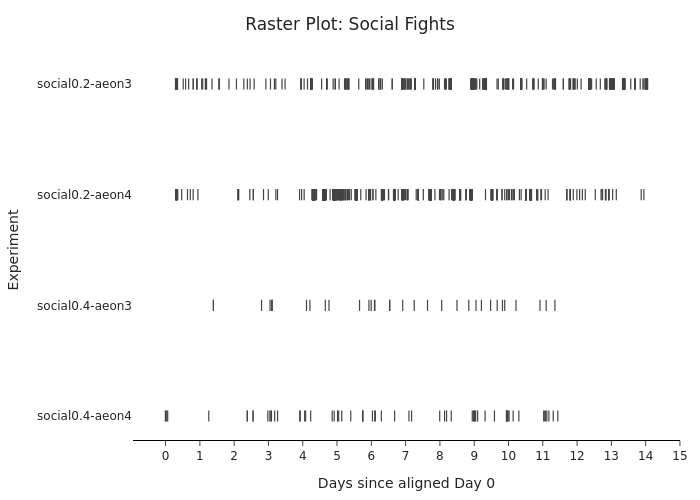

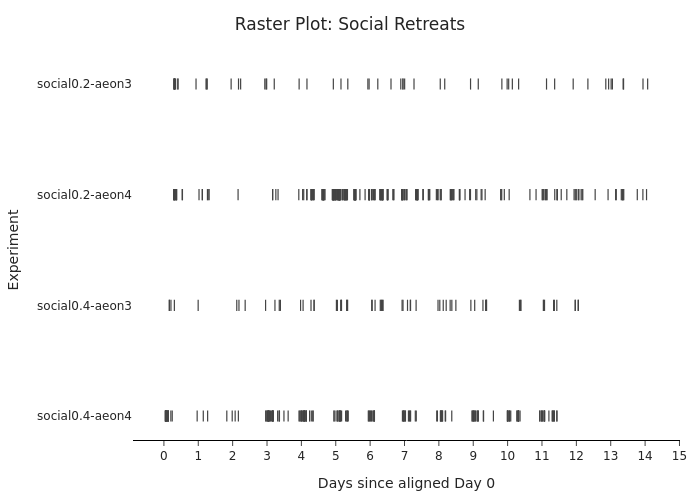

In [25]:
# Build lookup of social_start & compute per-exp offset to align at earliest start-time
exp_df = pd.DataFrame(experiments)
exp_df["social_start"] = pd.to_datetime(exp_df["social_start"])
exp_df["tod_sec"] = (
    exp_df["social_start"].dt.hour * 3600
    + exp_df["social_start"].dt.minute * 60
    + exp_df["social_start"].dt.second
)

# Earliest start-time (seconds since midnight)
min_tod = exp_df["tod_sec"].min()

# Offset seconds so each experiment’s Day 0 lines up at min_tod
exp_df["offset_sec"] = exp_df["tod_sec"] - min_tod

# Compute absolute baseline timestamp per experiment
exp_df["baseline_ts"] = exp_df["social_start"] - pd.to_timedelta(
    exp_df["offset_sec"], unit="s"
)
exp_df = exp_df[["name", "baseline_ts"]]

# Keep original experiment order
exp_order = [e["name"] for e in experiments]

dark_color = "#555555"

# Dataframes and titles to plot
raster_configs = [
    (social_fight_df_all_exps, "Raster Plot: Social Fights", "fights"),
    (social_retreat_df_all_exps, "Raster Plot: Social Retreats", "retreats"),
]

# Print aligned Day 0 hour (earliest start-time)
aligned_hour = min_tod // 3600
print(f"Aligned Day 0 starts at hour {aligned_hour}")

# Compute global end time across both datasets
all_events = pd.concat(
    [
        social_fight_df_all_exps[["experiment_name", "start_timestamp"]],
        social_retreat_df_all_exps[["experiment_name", "start_timestamp"]],
    ]
)
all_events["start_timestamp"] = pd.to_datetime(all_events["start_timestamp"])

# Merge baseline timestamps
all_events = all_events.merge(
    exp_df, left_on="experiment_name", right_on="name", how="left"
)

# Compute seconds since baseline
all_events["rel_sec"] = (
    all_events["start_timestamp"] - all_events["baseline_ts"]
).dt.total_seconds()

# Find last event
last = all_events.loc[all_events["rel_sec"].idxmax()]

# Compute end day and hour
end_day = int(last["rel_sec"] // 86400)
end_hour = int((last["rel_sec"] % 86400) // 3600)
print(f"Global end at Day {end_day}, hour {end_hour}")

# Plot each raster
for df, title, behavior in raster_configs:
    df2 = df[["experiment_name", "start_timestamp"]].copy()
    df2["start_timestamp"] = pd.to_datetime(df2["start_timestamp"])
    df2 = df2.merge(exp_df, left_on="experiment_name", right_on="name", how="left")

    # Compute rel_days
    df2["rel_days"] = (
        df2["start_timestamp"] - df2["baseline_ts"]
    ).dt.total_seconds() / 86400.0

    # Enforce experiment ordering
    df2["experiment_name"] = pd.Categorical(
        df2["experiment_name"], categories=exp_order, ordered=True
    )

    # Draw
    fig = go.Figure(
        go.Scatter(
            x=df2["rel_days"],
            y=df2["experiment_name"],
            mode="markers",
            marker=dict(symbol="line-ns", color=dark_color, size=8, line_width=1.2),
            showlegend=False,
            hovertemplate="Day: %{x:.2f}<br>Experiment: %{y}<extra></extra>",
        )
    )
    fig.update_yaxes(
        autorange="reversed",
        title_text="Experiment",
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks="",
    )
    fig.update_xaxes(
        title_text="Days since aligned Day 0",
        tick0=0,
        dtick=1,
        tickformat=".0f",
        showgrid=False,
        zeroline=False,
        showline=True,
        linecolor="black",
    )
    fig.update_layout(
        template="simple_white",
        margin=dict(l=120, r=20, t=60, b=40),
        height=100 + 20 * len(exp_order),
        title=dict(text=title, x=0.5),
    )

    # pio.write_image(
    #     fig,
    #     save_dir / f"{behavior}_raster.svg",
    #     format="svg"
    # )

    fig.show()

### 2. Proportion of retreat event wins over time during social period

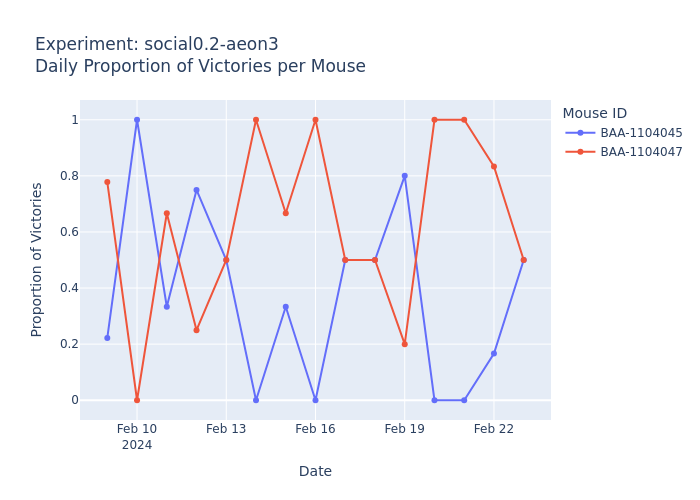

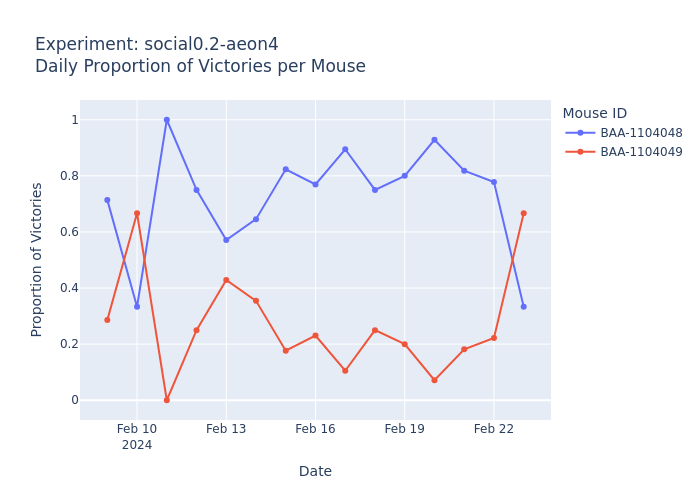

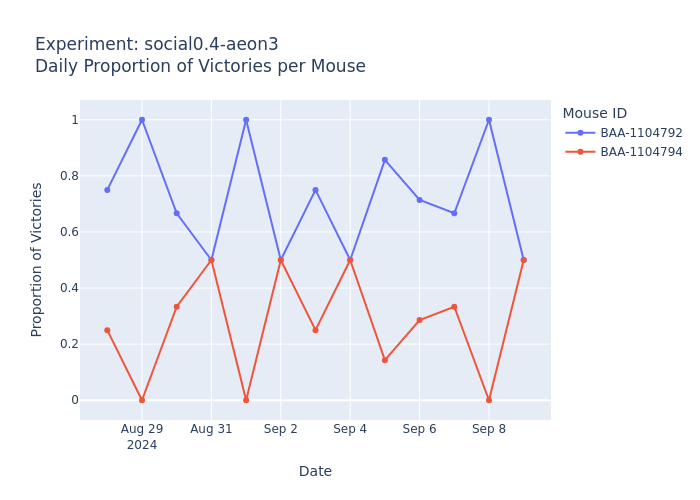

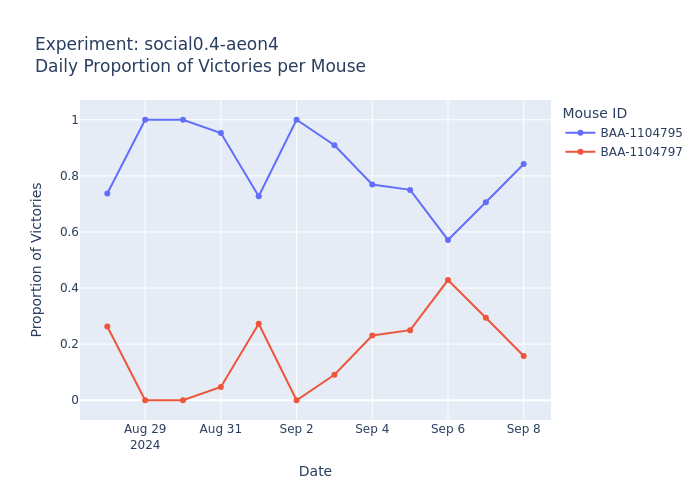

In [26]:
# NOT SMOOTHED
# Ensure 'end_timestamp' is datetime and extract 'date'
social_retreat_df_all_exps["end_timestamp"] = pd.to_datetime(
    social_retreat_df_all_exps["end_timestamp"]
)
social_retreat_df_all_exps["date"] = social_retreat_df_all_exps["end_timestamp"].dt.date

# Loop over each experiment_name’s subset and build one plot per experiment
for exp_name, df_group in social_retreat_df_all_exps.groupby("experiment_name"):
    # Compute daily win‐counts per mouse
    wins = df_group.groupby(["date", "winner_identity"]).size().unstack(fill_value=0)
    # Turn counts into proportions
    proportions = wins.div(wins.sum(axis=1), axis=0).reset_index()

    # Melt to long form for plotting
    df_long = proportions.melt(
        id_vars="date", var_name="winner_identity", value_name="proportion"
    )

    # Create and show one figure for this experiment
    fig = px.line(
        df_long,
        x="date",
        y="proportion",
        color="winner_identity",
        markers=True,
        title=f"Experiment: {exp_name}<br>Daily Proportion of Victories per Mouse",
    )
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Proportion of Victories",
        legend_title="Mouse ID",
    )
    fig.show()

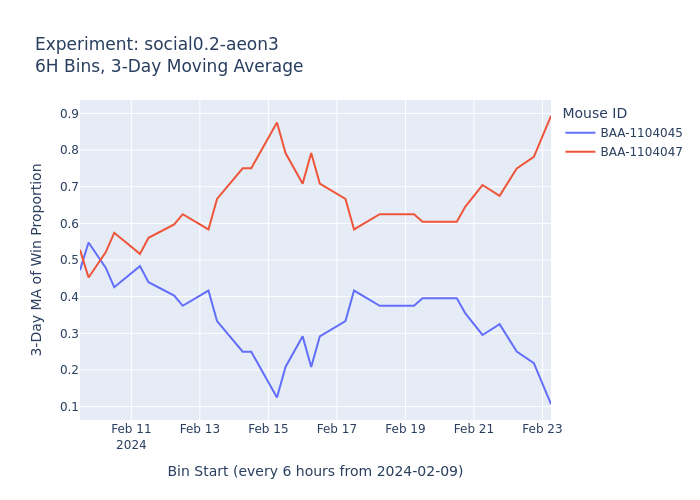

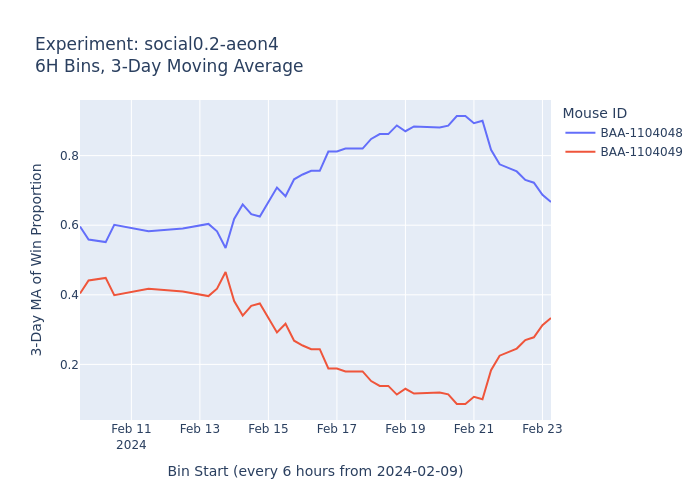

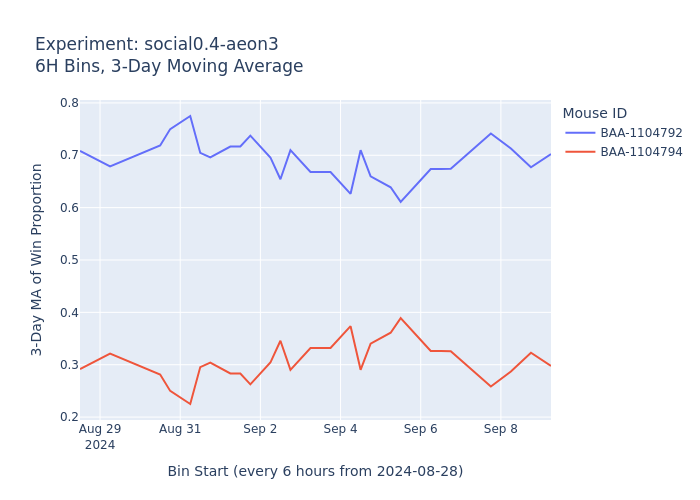

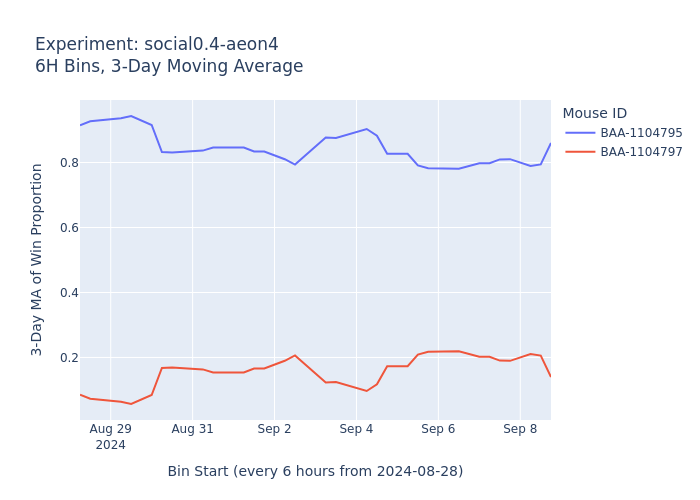

Average number of retreat events per experiment-day: 9.89


In [27]:
# SMOOTHED
# Parameters
BIN_HOURS = 6  # how many hours per bin (e.g. 6, 8, 10, 12, etc.)
SMOOTH_DAYS = 3  # how many days to smooth over (e.g. 3, 5, 7, etc.)

# Ensure 'end_timestamp' is datetime
social_retreat_df_all_exps["end_timestamp"] = pd.to_datetime(
    social_retreat_df_all_exps["end_timestamp"]
)

# Loop over each experiment_name’s subset and build one plot per experiment
for exp_name, df_group in social_retreat_df_all_exps.groupby("experiment_name"):
    df_group = df_group.copy()

    # Compute bin start for each timestamp
    earliest_midnight = df_group["end_timestamp"].dt.normalize().min()
    bin_size = pd.Timedelta(hours=BIN_HOURS)
    offsets = df_group["end_timestamp"] - earliest_midnight
    n_bins = (offsets // bin_size).astype(int)
    df_group["bin_start"] = earliest_midnight + n_bins * bin_size

    # Compute win-counts per bin per mouse
    wins = (
        df_group.groupby(["bin_start", "winner_identity"]).size().unstack(fill_value=0)
    )

    # Drop bins with zero total wins
    wins = wins[wins.sum(axis=1) > 0]

    # Turn counts into proportions
    proportions = wins.div(wins.sum(axis=1), axis=0).reset_index()

    # Melt to long form for plotting
    df_long = proportions.melt(
        id_vars="bin_start", var_name="winner_identity", value_name="proportion"
    )

    # Compute moving average window size (in bins)
    window_size = int((SMOOTH_DAYS * 24) / BIN_HOURS)
    window_size = max(window_size, 1)

    # Apply centered moving average per mouse
    df_long = df_long.sort_values(["winner_identity", "bin_start"])
    df_long["smoothed_prop"] = df_long.groupby("winner_identity")[
        "proportion"
    ].transform(
        lambda s: s.rolling(window=window_size, center=True, min_periods=1).mean()
    )

    # Create and show one figure for this experiment
    fig = px.line(
        df_long,
        x="bin_start",
        y="smoothed_prop",
        color="winner_identity",
        markers=False,
        title=(
            f"Experiment: {exp_name}<br>"
            f"{BIN_HOURS}H Bins, {SMOOTH_DAYS}‐Day Moving Average"
        ),
    )
    fig.update_layout(
        xaxis_title=f"Bin Start (every {BIN_HOURS} hours from {earliest_midnight.date()})",
        yaxis_title=f"{SMOOTH_DAYS}‐Day MA of Win Proportion",
        legend_title="Mouse ID",
    )
    fig.show()

    # if exp_name == experiments[-1]['name']:
    # pio.write_image(
    #     fig,
    #     str(save_dir / f"social_retreat_{BIN_HOURS}h_bins_{SMOOTH_DAYS}day_smooth.svg"),
    #     format="svg"
    # )

# Compute average number of retreat events per experiment-day
social_retreat_df_all_exps["start_timestamp"] = pd.to_datetime(
    social_retreat_df_all_exps["start_timestamp"]
)
# Extract day from timestamp
social_retreat_df_all_exps["day"] = social_retreat_df_all_exps[
    "start_timestamp"
].dt.floor("D")
# Count events per (experiment, day)
daily_counts = social_retreat_df_all_exps.groupby(["experiment_name", "day"]).size()
# Compute global average
avg_events_per_day = daily_counts.mean()
print(f"Average number of retreat events per experiment-day: {avg_events_per_day:.2f}")

### 3. Pre/during/post tube test comparison

Wilcoxon signed-rank: W = 2.000, p-value = 0.375


=== social0.2-aeon3 (BAA-1104047 dominant) ===
Pooled Pre+Post: wins=17/20 → binom p=0.001
Social:          wins=35/55 → binom p=0.029


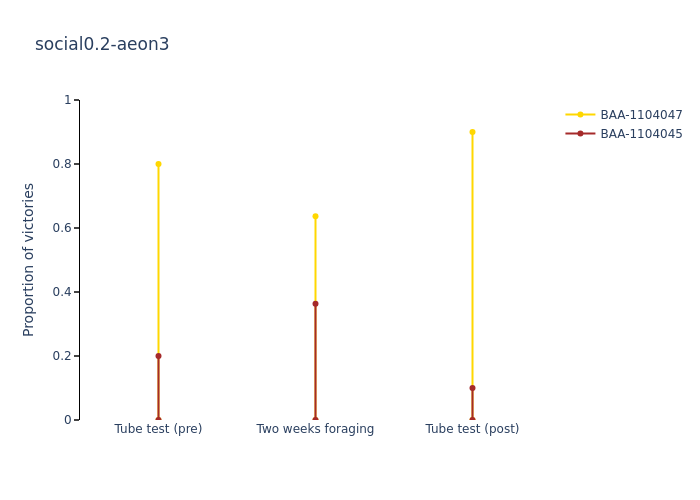


=== social0.2-aeon4 (BAA-1104048 dominant) ===
Pooled Pre+Post: wins=15/20 → binom p=0.021
Social:          wins=183/251 → binom p=0.000


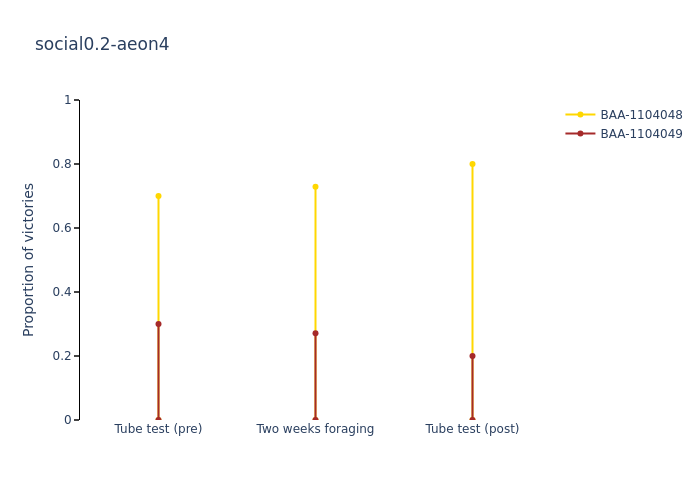


=== social0.4-aeon3 (BAA-1104792 dominant) ===
Pooled Pre+Post: wins=25/31 → binom p=0.000
Social:          wins=47/66 → binom p=0.000


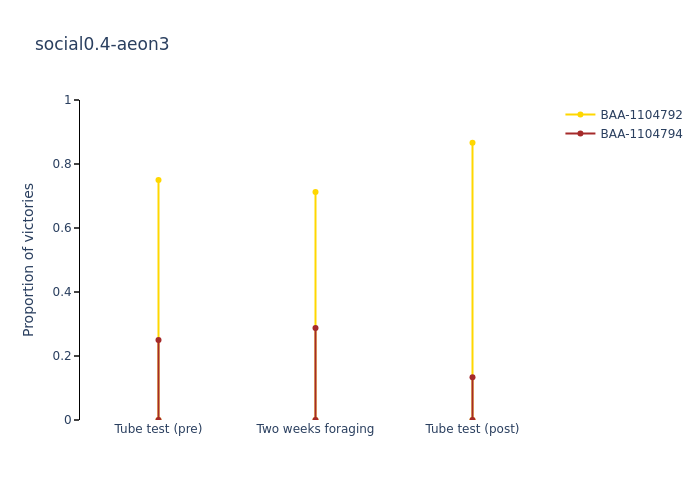


=== social0.4-aeon4 (BAA-1104795 dominant) ===
Pooled Pre+Post: wins=22/29 → binom p=0.004
Social:          wins=139/172 → binom p=0.000


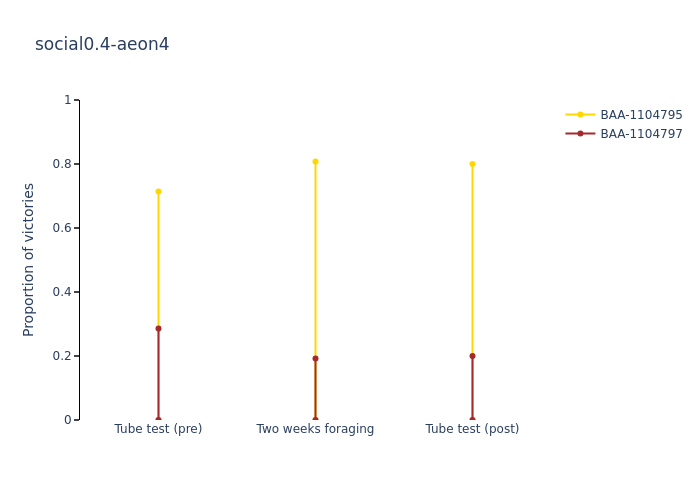

In [28]:
# Total win counts per subject during social phase
social_counts_df = (
    social_retreat_df_all_exps.groupby(["experiment_name", "winner_identity"])
    .size()
    .unstack(fill_value=0)
)

# Compute per-experiment summary metrics for dominant subject
records = []
for exp, subj_dict in tube_test_data.items():
    soc_counts = social_counts_df.loc[exp]
    total_pre = sum(d["pre"] for d in subj_dict.values())
    total_post = sum(d["post"] for d in subj_dict.values())
    total_soc = soc_counts.sum()

    # Identify dominant by total wins across all phases
    total_wins = {
        subj: subj_dict[subj]["pre"] + soc_counts.get(subj, 0) + subj_dict[subj]["post"]
        for subj in subj_dict
    }
    dominant = max(total_wins, key=total_wins.get)

    # Compute win rates for dominant subject
    pre_rate = subj_dict[dominant]["pre"] / total_pre
    social_rate = soc_counts[dominant] / total_soc
    post_rate = subj_dict[dominant]["post"] / total_post
    baseline_rate = (subj_dict[dominant]["pre"] + subj_dict[dominant]["post"]) / (
        total_pre + total_post
    )

    records.append(
        {
            "experiment": exp,
            "dominant": dominant,
            "pre_rate": pre_rate,
            "social_rate": social_rate,
            "post_rate": post_rate,
            "baseline_rate": baseline_rate,
        }
    )

summary_df = pd.DataFrame(records)

# Test: is social-phase rate higher than pre+post (Wilcoxon signed-rank)
stat, p_value = wilcoxon(summary_df["baseline_rate"], summary_df["social_rate"])
print(f"Wilcoxon signed-rank: W = {stat:.3f}, p-value = {p_value:.3f}\n")

# Per-experiment plotting and binomial tests
x_positions = [0, 1, 2]
x_labels = ["Tube test (pre)", "Two weeks foraging", "Tube test (post)"]

for experiment, subjects in tube_test_data.items():
    ids = list(subjects.keys())
    pre_scores = {s: subjects[s]["pre"] for s in ids}
    post_scores = {s: subjects[s]["post"] for s in ids}
    soc_counts = social_counts_df.loc[experiment]

    # Identify dominant and subordinate
    dominant = summary_df.loc[summary_df["experiment"] == experiment, "dominant"].iloc[
        0
    ]
    subordinate = [s for s in ids if s != dominant][0]

    # Win/loss counts
    k_pre = pre_scores[dominant]
    n_pre = k_pre + pre_scores[subordinate]
    k_post = post_scores[dominant]
    n_post = k_post + post_scores[subordinate]
    k_social = soc_counts[dominant]
    n_social = soc_counts.sum()

    # Binomial tests (one-sided: dominant > 50%)
    k_pool = k_pre + k_post
    n_pool = n_pre + n_post
    p_pool = binomtest(k_pool, n_pool, p=0.5, alternative="greater").pvalue
    p_social = binomtest(k_social, n_social, p=0.5, alternative="greater").pvalue

    # Print results
    print(f"\n=== {experiment} ({dominant} dominant) ===")
    print(f"Pooled Pre+Post: wins={k_pool}/{n_pool} → binom p={p_pool:.3f}")
    print(f"Social:          wins={k_social}/{n_social} → binom p={p_social:.3f}")

    # Plot win rates for both mice
    proportions = {
        dominant: {
            "pre": k_pre / n_pre,
            "social": k_social / n_social,
            "post": k_post / n_post,
            "color": "gold",
        },
        subordinate: {
            "pre": pre_scores[subordinate] / n_pre,
            "social": soc_counts[subordinate] / n_social,
            "post": post_scores[subordinate] / n_post,
            "color": "brown",
        },
    }

    fig = go.Figure()
    for subj, vals in proportions.items():
        for i, x in enumerate(x_positions):
            y = [vals["pre"], vals["social"], vals["post"]][i]
            fig.add_trace(
                go.Scatter(
                    x=[x, x],
                    y=[0, y],
                    mode="lines+markers",
                    name=subj,
                    line=dict(color=vals["color"]),
                    showlegend=(i == 0),
                )
            )

    fig.update_layout(
        title=experiment,
        plot_bgcolor="white",
        width=400,
        height=400,
        xaxis=dict(tickvals=x_positions, ticktext=x_labels, range=[-0.5, 2.5]),
        yaxis=dict(
            title="Proportion of victories",
            range=[0, 1],
            ticks="outside",
            ticklen=5,
            tickwidth=2,
            showline=True,
            linecolor="black",
        ),
    )
    fig.show()

    # if experiment == experiments[-1]['name']:
    #     pio.write_image(
    #         fig,
    #         str(save_dir / f"tube_test_win_rates.svg"),
    #         format="svg"
    #     )

### 4. Dominance summary plot

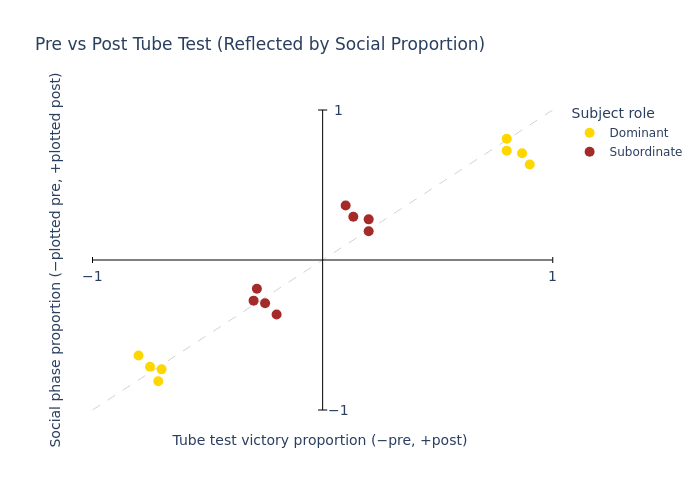

In [29]:
social_win_proportions = (
    social_retreat_df_all_exps.groupby(["experiment_name", "winner_identity"])
    .size()
    .unstack(fill_value=0)
)
social_win_proportions = social_win_proportions.div(
    social_win_proportions.sum(axis=1), axis=0
)

# Define plot
fig = go.Figure()
legend_labels_added = {"gold": False, "brown": False}

for experiment, subjects in tube_test_data.items():
    ids = list(subjects.keys())
    pre_scores = {subj: subjects[subj]["pre"] for subj in ids}
    post_scores = {subj: subjects[subj]["post"] for subj in ids}

    pre_dominant = max(pre_scores, key=pre_scores.get)
    post_dominant = max(post_scores, key=post_scores.get)

    if experiment in social_win_proportions.index:
        social_scores = social_win_proportions.loc[experiment]
        social_dominant = social_scores.idxmax()
    else:
        raise ValueError(f"No social data for {experiment}")

    if len({pre_dominant, post_dominant, social_dominant}) != 1:
        raise ValueError(
            f"Inconsistent dominant subject in {experiment}: pre={pre_dominant}, social={social_dominant}, post={post_dominant}"
        )

    dominant = pre_dominant
    subordinate = [s for s in ids if s != dominant][0]

    total_pre = pre_scores[dominant] + pre_scores[subordinate]
    total_post = post_scores[dominant] + post_scores[subordinate]

    social_dom = (
        social_win_proportions.at[experiment, dominant]
        if dominant in social_win_proportions.columns
        else 0
    )
    social_sub = (
        social_win_proportions.at[experiment, subordinate]
        if subordinate in social_win_proportions.columns
        else 0
    )

    proportions = {
        dominant: {
            "pre": -pre_scores[dominant] / total_pre,
            "post": post_scores[dominant] / total_post,
            "social": -social_dom,
            "color": "gold",
            "legend": "Dominant",
        },
        subordinate: {
            "pre": -pre_scores[subordinate] / total_pre,
            "post": post_scores[subordinate] / total_post,
            "social": -social_sub,
            "color": "brown",
            "legend": "Subordinate",
        },
    }

    for subj, vals in proportions.items():
        color = vals["color"]
        legend_name = vals["legend"] if not legend_labels_added[color] else None
        legend_labels_added[color] = True

        # Pre point
        fig.add_trace(
            go.Scatter(
                x=[vals["pre"]],
                y=[vals["social"]],
                mode="markers",
                marker=dict(color=color, size=10),
                name=legend_name,
                showlegend=legend_name is not None,
            )
        )

        # Post point
        fig.add_trace(
            go.Scatter(
                x=[vals["post"]],
                y=[-vals["social"]],
                mode="markers",
                marker=dict(color=color, size=10),
                name=legend_name,
                showlegend=False,
            )
        )

# Final layout
# Hide everything
fig.update_xaxes(
    showgrid=False, showline=False, zeroline=False, showticklabels=False, ticks=""
)
fig.update_yaxes(
    showgrid=False, showline=False, zeroline=False, showticklabels=False, ticks=""
)

# Draw the two axes as black lines
fig.add_shape(type="line", x0=-1, x1=1, y0=0, y1=0, line=dict(color="black", width=1))
fig.add_shape(type="line", x0=0, x1=0, y0=-1, y1=1, line=dict(color="black", width=1))

# Draw little ticks at ±1
tick_len = 0.02
for t in (-1, 1):
    # x‐axis tick
    fig.add_shape(
        type="line",
        x0=t,
        x1=t,
        y0=-tick_len,
        y1=+tick_len,
        line=dict(color="black", width=1),
    )
    # y‐axis tick
    fig.add_shape(
        type="line",
        x0=-tick_len,
        x1=+tick_len,
        y0=t,
        y1=t,
        line=dict(color="black", width=1),
    )

# Annotate labels at ±1
for t, txt in [(-1, "−1"), (1, "1")]:
    # x‐axis label
    fig.add_annotation(
        x=t,
        y=0,
        text=txt,
        yshift=-16,  # move it down in px
        showarrow=False,
        font=dict(size=14),
    )
    # y‐axis label
    fig.add_annotation(
        x=0,
        y=t,
        text=txt,
        xshift=16,  # move it left in px
        showarrow=False,
        font=dict(size=14),
    )

# Finally, re-add title & legend layout
fig.update_layout(
    title="Pre vs Post Tube Test (Reflected by Social Proportion)",
    plot_bgcolor="white",
    width=700,
    height=700,
    legend=dict(title="Subject role", orientation="v", x=1.02, y=1),
)

# Draw y=x as a dashed grey line (behind the points)
fig.add_shape(
    type="line",
    x0=-1,
    y0=-1,
    x1=1,
    y1=1,
    line=dict(color="lightgrey", width=1, dash="dash"),
    layer="below",
)

# Re-add title, legend, and now axis titles
fig.update_layout(
    title="Pre vs Post Tube Test (Reflected by Social Proportion)",
    xaxis_title="Tube test victory proportion (−pre, +post)",
    yaxis_title="Social phase proportion (−plotted pre, +plotted post)",
    plot_bgcolor="white",
    width=700,
    height=700,
    legend=dict(title="Subject role", orientation="v", x=1.02, y=1),
)

fig.show()

# pio.write_image(
#     fig,
#     str(save_dir / "tube_test_scatter.svg"),
#     format="svg"
# )

### 5. Dominant vs subordinate comparison of time spent and distance spun at best patch

In [30]:
df = social_patch_df_all_exps.merge(
    social_patchinfo_df_all_exps[
        ["experiment_name", "block_start", "patch_name", "patch_rate"]
    ],
    on=["experiment_name", "block_start", "patch_name"],
    how="left",
).assign(dummy=lambda x: x["patch_name"].str.contains("dummy", case=False))

# Keep only blocks where non-dummy patches have exactly 3 different rates
df = df[
    df.groupby(["experiment_name", "block_start"])["patch_rate"].transform(
        lambda s: s[~df.loc[s.index, "dummy"]].nunique() == 3
    )
]

# Create a ranking only for non-dummy patches
non_dummy_ranks = (
    df[~df["dummy"]]
    .groupby(["experiment_name", "block_start"])["patch_rate"]
    .rank(method="dense")
)

# Add the ranks back to the full dataframe
df["patch_rank"] = np.nan
df.loc[~df["dummy"], "patch_rank"] = non_dummy_ranks

# Assign difficulty (rank 1=hard, rank 3=easy, rank 2=medium)
df["patch_difficulty"] = np.where(
    df["dummy"],
    "dummy",
    np.where(
        df["patch_rank"] == 1, "hard", np.where(df["patch_rank"] == 3, "easy", "medium")
    ),
)

df = df.drop(columns=["patch_rank"])

In [31]:
# Compute social‐win proportions
swp = (
    social_retreat_df_all_exps.groupby(["experiment_name", "winner_identity"])
    .size()
    .unstack(fill_value=0)
)
swp = swp.div(swp.sum(axis=1), axis=0)

# Build the dominance DataFrame in one comprehension
dominance_df = pd.DataFrame(
    [
        {
            "experiment_name": exp,
            "dominant": dom,
            "subordinate": next(s for s in subs if s != dom),
        }
        for exp, subs in tube_test_data.items()
        if exp in swp.index
        # pick the pre‐tube top scorer…
        for dom in [max(subs, key=lambda s: subs[s]["pre"])]
        # …only keep if post‐tube and social‐win agree
        if dom == max(subs, key=lambda s: subs[s]["post"]) == swp.loc[exp].idxmax()
    ]
)

dominance_df

,experiment_name,dominant,subordinate
0,social0.2-aeon3,BAA-1104047,BAA-1104045
1,social0.2-aeon4,BAA-1104048,BAA-1104049
2,social0.4-aeon3,BAA-1104792,BAA-1104794
3,social0.4-aeon4,BAA-1104795,BAA-1104797


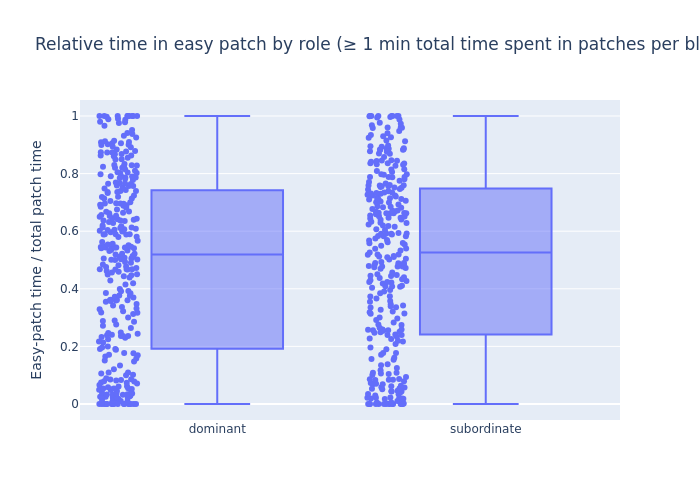

Median easy patch time ratio by role:
dominant: 0.52
subordinate: 0.53


In [32]:
# Compute per‐subject, per‐block easy‐time fraction, but only keep blocks ≥1 min
time_df = (
    df.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "in_patch_time"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    .assign(total_time=lambda d: d.sum(axis=1))
    # filter out blocks with < 60 s total patch time
    .loc[lambda d: d["total_time"] >= 60]
    .assign(easy_ratio=lambda d: d["easy"] / d["total_time"])
    .reset_index()
)

# Merge in dominant/subordinate labels and tag role
time_df = time_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)

# Box‐plot of easy_ratio by role
fig = px.box(
    time_df,
    x="role",
    y="easy_ratio",
    points="all",
    category_orders={"role": ["dominant", "subordinate"]},
    title="Relative time in easy patch by role (≥ 1 min total time spent in patches per block)",
)
fig.update_yaxes(title="Easy‐patch time / total patch time")
fig.update_xaxes(title="")
fig.show()

# Print the medians
medians = time_df.groupby("role")["easy_ratio"].median()
print("Median easy patch time ratio by role:")
for role, median in medians.items():
    print(f"{role}: {median:.2f}")

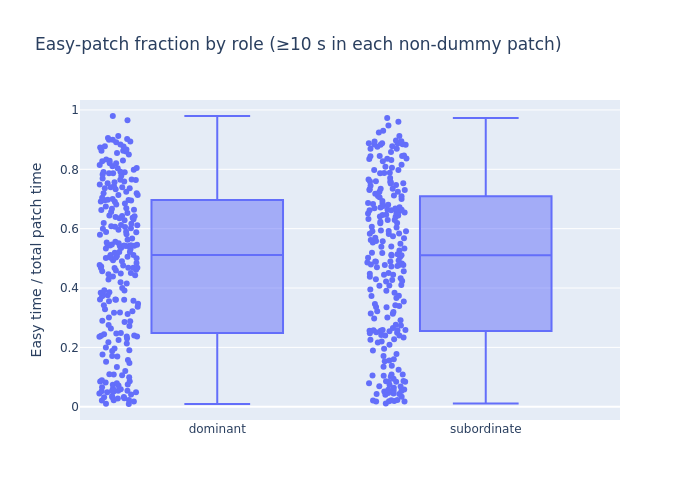

In [33]:
# Get per‐subject, per‐block time by difficulty
time_df = (
    df.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "in_patch_time"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    # drop any block‐subject that didn’t spend ≥10 s in each of hard/medium/easy
    .loc[lambda d: (d[["hard", "medium", "easy"]] >= 10).all(axis=1)]
    .assign(
        total_time=lambda d: d.sum(axis=1),
        easy_ratio=lambda d: d["easy"] / d["total_time"],
    )
    .reset_index()
)

# Merge in dominant/subordinate and label role
time_df = time_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)

# Box‐plot of easy_ratio by role
fig = px.box(
    time_df,
    x="role",
    y="easy_ratio",
    points="all",
    category_orders={"role": ["dominant", "subordinate"]},
    title="Easy‐patch fraction by role (≥10 s in each non‐dummy patch)",
)
fig.update_yaxes(title="Easy time / total patch time")
fig.update_xaxes(title="")
fig.show()


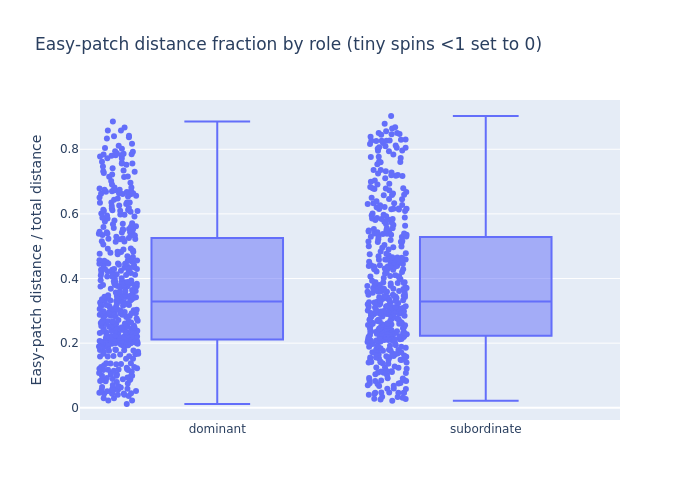

Median easy patch distance ratio by role:
dominant: 0.33
subordinate: 0.33


In [34]:
# Compute true traveled distance for each patch‐visit, thresholding <1→0
df2 = (
    df.assign(
        # sum of abs steps = true distance
        traveled=lambda d: d["wheel_cumsum_distance_travelled"].apply(
            lambda arr: np.sum(np.abs(np.diff(arr))) if len(arr) > 1 else 0
        )
    )
    # any tiny (<1) distance becomes 0
    .assign(traveled=lambda d: d["traveled"].mask(d["traveled"] < 1, 0))
)

# Pivot to one row per subject‐block with columns [hard, medium, easy]
dist_df = (
    df2.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "traveled"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    .assign(
        total_dist=lambda d: d.sum(axis=1),
        easy_ratio=lambda d: d["easy"] / d["total_dist"],
    )
    .reset_index()
)

# Merge in dominance & tag role
dist_df = dist_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)

# Box‐plot of easy_ratio by role
fig = px.box(
    dist_df,
    x="role",
    y="easy_ratio",
    points="all",
    category_orders={"role": ["dominant", "subordinate"]},
    title="Easy‐patch distance fraction by role (tiny spins <1 set to 0)",
)
fig.update_yaxes(title="Easy‐patch distance / total distance")
fig.update_xaxes(title="")
fig.show()

# Print the medians
medians = dist_df.groupby("role")["easy_ratio"].median()
print("Median easy patch distance ratio by role:")
for role, median in medians.items():
    print(f"{role}: {median:.2f}")

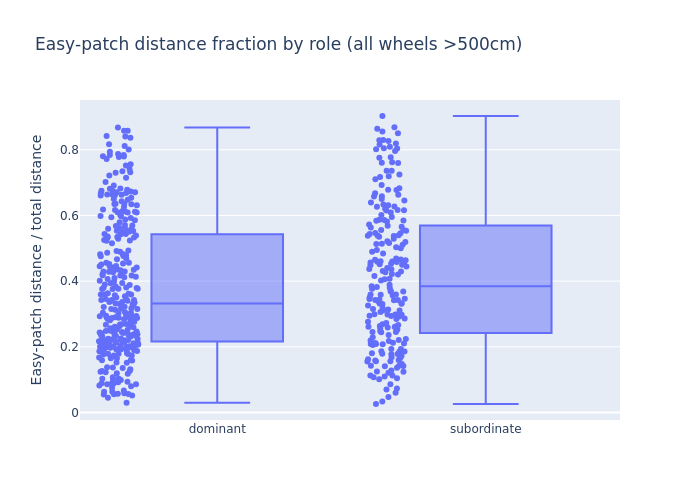

In [35]:
# Compute true traveled distance per patch‐visit, tiny spins → 0
df2 = df.assign(
    traveled=lambda d: d["wheel_cumsum_distance_travelled"].apply(
        lambda arr: np.sum(np.abs(np.diff(arr))) if len(arr) > 1 else 0
    )
).assign(traveled=lambda d: d["traveled"].mask(d["traveled"] < 1, 0))

# Pivot to one row per subject‐block, but only keep rows where hard,medium,easy >5
dist_df = (
    df2.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "traveled"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    .loc[lambda d: (d[["hard", "medium", "easy"]] > 500).all(axis=1)]
    .assign(
        total_dist=lambda d: d.sum(axis=1),
        easy_ratio=lambda d: d["easy"] / d["total_dist"],
    )
    .reset_index()
)

# Merge in dominance & tag role
dist_df = dist_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)

# Box‐plot of easy_ratio by role (dominant first)
fig = px.box(
    dist_df,
    x="role",
    y="easy_ratio",
    points="all",
    category_orders={"role": ["dominant", "subordinate"]},
    title="Easy‐patch distance fraction by role (all wheels >500cm)",
)
fig.update_yaxes(title="Easy‐patch distance / total distance")
fig.update_xaxes(title="")
fig.show()


## Patch preference plots

### Load data

In [ ]:
data = load_experiment_data(
    data_dir=data_dir,
    data_types=["patch", "patchinfo"],
)

patch_df = data["None_patch"]
patch_info_df = data["None_patchinfo"]

In [37]:
block_subject_patch_data_social_combined = patch_df[
    patch_df["period"] == "social"
].copy()
block_subject_patch_data_social_combined.drop(columns=["period"], inplace=True)
block_subject_patch_data_social_dict = patch_df_to_dict(
    block_subject_patch_data_social_combined
)
block_subject_patch_data_post_social_combined = patch_df[
    patch_df["period"] == "postsocial"
].copy()
block_subject_patch_data_post_social_combined.drop(columns=["period"], inplace=True)
block_subject_patch_data_post_social_dict = patch_df_to_dict(
    block_subject_patch_data_post_social_combined
)
block_subject_patch_data_social_first_half_combined = get_first_half_social(
    patch_df
).copy()
block_subject_patch_data_social_first_half_combined.drop(
    columns=["period"], inplace=True
)
block_subject_patch_data_social_first_half_dict = patch_df_to_dict(
    block_subject_patch_data_social_first_half_combined
)
patch_info_dict = patch_info_df_to_dict(patch_info_df)

### 1. Wheel distance spun per block, averaged by the number of mice

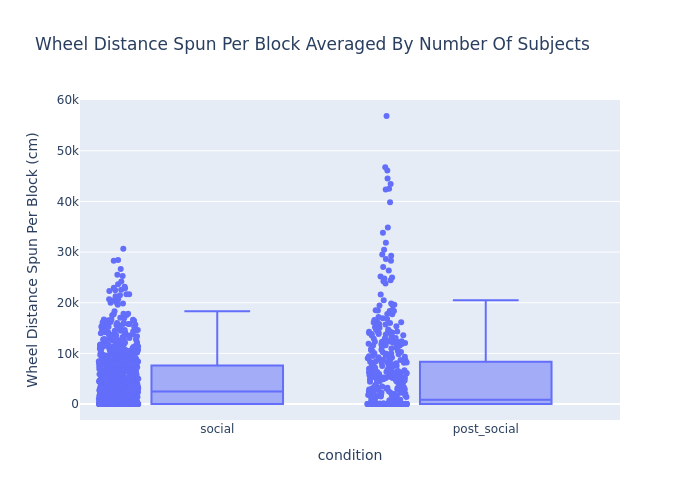

In [38]:
block_subject_patch_data_social_combined["final_wheel_cumsum"] = (
    block_subject_patch_data_social_combined["wheel_cumsum_distance_travelled"].apply(
        lambda x: x[-1] if isinstance(x, np.ndarray) and len(x) > 0 else 0
    )
)
wheel_total_dist_averaged_social = (
    block_subject_patch_data_social_combined.groupby("block_start")[
        "final_wheel_cumsum"
    ].sum()
    / 2
)
wheel_total_dist_averaged_social = wheel_total_dist_averaged_social.reset_index()

block_subject_patch_data_post_social_combined["final_wheel_cumsum"] = (
    block_subject_patch_data_post_social_combined[
        "wheel_cumsum_distance_travelled"
    ].apply(lambda x: x[-1] if isinstance(x, np.ndarray) and len(x) > 0 else 0)
)
wheel_total_dist_averaged_post_social = (
    block_subject_patch_data_post_social_combined.groupby("block_start")[
        "final_wheel_cumsum"
    ]
    .sum()
    .reset_index()
)

wheel_total_dist_averaged_social["condition"] = "social"
wheel_total_dist_averaged_post_social["condition"] = "post_social"
wheel_total_dist_averaged = pd.concat(
    [wheel_total_dist_averaged_social, wheel_total_dist_averaged_post_social]
)

fig = go.Figure()

fig = px.box(
    wheel_total_dist_averaged,
    x="condition",
    y="final_wheel_cumsum",
    points="all",
    title="Wheel Distance Spun Per Block Averaged By Number Of Subjects",
    labels={"final_wheel_cumsum": "Wheel Distance Spun Per Block (cm)"},
)
fig.show()

### 2. Number of patch switches by each mouse per block

In [40]:
prob_per_patch_social_first_half_dict = {}
prob_per_patch_social_dict = {}
prob_per_patch_post_social_dict = {}
prob_hard_patch_social_first_half_dict = {}
prob_hard_patch_social_dict = {}
prob_hard_patch_post_social_dict = {}
prob_hard_patch_mean_social_first_half_dict = {}
prob_hard_patch_mean_social_dict = {}
prob_hard_patch_mean_post_social_dict = {}

for exp in experiments:
    exp_name = exp["name"]
    block_subject_patch_data_social_first_half = (
        block_subject_patch_data_social_first_half_dict[exp_name]
    )
    block_subject_patch_data_social = block_subject_patch_data_social_dict[exp_name]
    block_subject_patch_data_post_social = block_subject_patch_data_post_social_dict[
        exp_name
    ]
    patch_info = patch_info_dict[exp_name]

    # Compute patch probabilities
    prob_per_patch_social_first_half_dict[exp_name] = compute_patch_probabilities(
        block_subject_patch_data_social_first_half
    )
    prob_per_patch_social_dict[exp_name] = compute_patch_probabilities(
        block_subject_patch_data_social
    )
    prob_per_patch_post_social_dict[exp_name] = compute_patch_probabilities(
        block_subject_patch_data_post_social
    )

    # Extract hard patch probabilities
    prob_hard_patch_social_first_half_dict[exp_name] = extract_hard_patch_probabilities(
        prob_per_patch_social_first_half_dict[exp_name], patch_info
    )
    prob_hard_patch_social_dict[exp_name] = extract_hard_patch_probabilities(
        prob_per_patch_social_dict[exp_name], patch_info
    )
    prob_hard_patch_post_social_dict[exp_name] = extract_hard_patch_probabilities(
        prob_per_patch_post_social_dict[exp_name], patch_info
    )

    # Calculate the mean hard patch probability per pellet number
    prob_hard_patch_mean_social_first_half_dict[exp_name] = (
        prob_hard_patch_social_first_half_dict[exp_name]
        .groupby("pellet_number")
        .mean(numeric_only=True)
        .reset_index()
    )
    prob_hard_patch_mean_social_dict[exp_name] = (
        prob_hard_patch_social_dict[exp_name]
        .groupby("pellet_number")
        .mean(numeric_only=True)
        .reset_index()
    )
    prob_hard_patch_mean_post_social_dict[exp_name] = (
        prob_hard_patch_post_social_dict[exp_name]
        .groupby("pellet_number")
        .mean(numeric_only=True)
        .reset_index()
    )

# Combine the results
prob_hard_patch_social_first_half_combined = pd.concat(
    prob_hard_patch_social_first_half_dict.values()
)
prob_hard_patch_social_combined = pd.concat(prob_hard_patch_social_dict.values())
prob_hard_patch_post_social_combined = pd.concat(
    prob_hard_patch_post_social_dict.values()
)

prob_hard_patch_mean_social_first_half_combined = (
    prob_hard_patch_social_first_half_combined.groupby("pellet_number")
    .mean(numeric_only=True)
    .reset_index()
)
prob_hard_patch_mean_social_combined = (
    prob_hard_patch_social_combined.groupby("pellet_number")
    .mean(numeric_only=True)
    .reset_index()
)
prob_hard_patch_mean_post_social_combined = (
    prob_hard_patch_post_social_combined.groupby("pellet_number")
    .mean(numeric_only=True)
    .reset_index()
)

In [41]:
model_social_first_half, y_pred_social_first_half = analyze_patch_probabilities(
    prob_hard_patch_mean_social_first_half_combined, "social first half"
)
model_social, y_pred_social = analyze_patch_probabilities(
    prob_hard_patch_mean_social_combined, "social"
)
model_post_social, y_pred_post_social = analyze_patch_probabilities(
    prob_hard_patch_mean_post_social_combined, "post-social"
)

P-value for the social first half slope: 5.936891089220609e-14
social first half model summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     153.4
Date:                Thu, 21 Aug 2025   Prob (F-statistic):           5.94e-14
Time:                        17:37:33   Log-Likelihood:                 93.236
No. Observations:                  35   AIC:                            -182.5
Df Residuals:                      33   BIC:                            -179.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

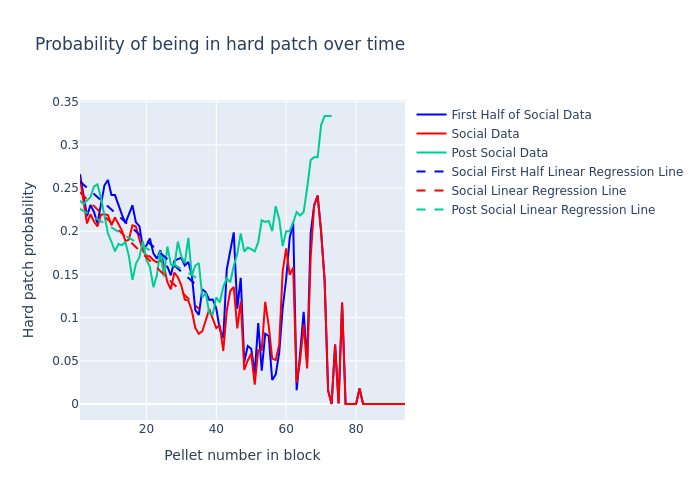

In [42]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=prob_hard_patch_mean_social_first_half_combined["pellet_number"],  # [0:35],
        y=prob_hard_patch_mean_social_first_half_combined[
            "prob_in_hard_patch"
        ],  # [0:35],
        mode="lines",
        name="First Half of Social Data",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Scatter(
        x=prob_hard_patch_mean_social_combined["pellet_number"],  # [0:35],
        y=prob_hard_patch_mean_social_combined["prob_in_hard_patch"],  # [0:35],
        mode="lines",
        name="Social Data",
        marker=dict(color="red"),
    )
)

fig.add_trace(
    go.Scatter(
        x=prob_hard_patch_mean_post_social_combined["pellet_number"],  # [0:35],
        y=prob_hard_patch_mean_post_social_combined["prob_in_hard_patch"],  # [0:35],
        mode="lines",
        name="Post Social Data",
        marker=dict(color="#00CC96"),
    )
)

fig.add_trace(
    go.Scatter(
        x=prob_hard_patch_mean_social_first_half_combined["pellet_number"][0:35],
        y=y_pred_social_first_half,
        mode="lines",
        name="Social First Half Linear Regression Line",
        line=dict(dash="dash"),
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Scatter(
        x=prob_hard_patch_mean_social_combined["pellet_number"][0:35],
        y=y_pred_social,
        mode="lines",
        name="Social Linear Regression Line",
        line=dict(dash="dash"),
        marker=dict(color="red"),
    )
)

fig.add_trace(
    go.Scatter(
        x=prob_hard_patch_mean_social_combined["pellet_number"][0:35],
        y=y_pred_post_social,
        mode="lines",
        name="Post Social Linear Regression Line",
        line=dict(dash="dash"),
        marker=dict(color="#00CC96"),
    )
)

fig.update_layout(
    title="Probability of being in hard patch over time",
    xaxis_title="Pellet number in block",
    yaxis_title="Hard patch probability",
)

fig.show()

# Save the figure as an SVG file
# fig.write_image("hard_patch_probability.svg")

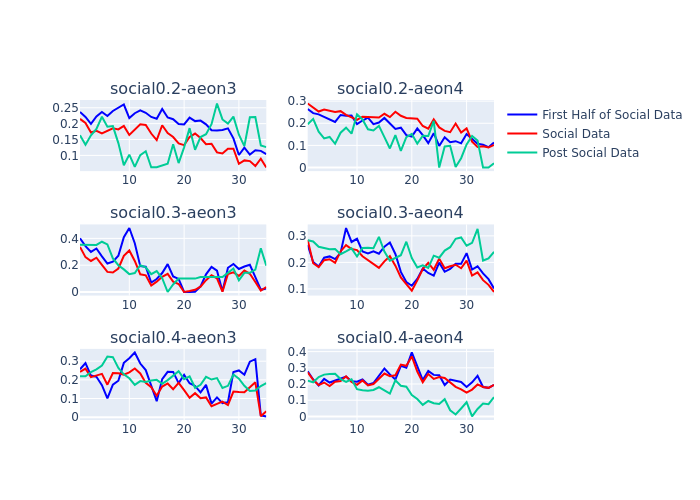

In [43]:
# Define the number of rows and columns for the subplot grid
num_experiments = len(experiments)
num_cols = 2
num_rows = (num_experiments + num_cols - 1) // num_cols

# Create a subplot grid
fig = make_subplots(
    rows=num_rows, cols=num_cols, subplot_titles=[exp["name"] for exp in experiments]
)

# Iterate over each experiment and add a plot to the grid
for i, exp in enumerate(experiments):
    exp_name = exp["name"]
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    # Add the plot to the grid
    fig.add_trace(
        go.Scatter(
            x=prob_hard_patch_mean_social_first_half_dict[exp_name]["pellet_number"][
                0:35
            ],
            y=prob_hard_patch_mean_social_first_half_dict[exp_name][
                "prob_in_hard_patch"
            ][0:35],
            mode="lines",
            name="First Half of Social Data",
            marker=dict(color="blue"),
            showlegend=(i == 0),
        ),
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=prob_hard_patch_mean_social_dict[exp_name]["pellet_number"][0:35],
            y=prob_hard_patch_mean_social_dict[exp_name]["prob_in_hard_patch"][0:35],
            mode="lines",
            name="Social Data",
            marker=dict(color="red"),
            showlegend=(i == 0),
        ),
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=prob_hard_patch_mean_post_social_dict[exp_name]["pellet_number"][0:35],
            y=prob_hard_patch_mean_post_social_dict[exp_name]["prob_in_hard_patch"][
                0:35
            ],
            mode="lines",
            name="Post Social Data",
            marker=dict(color="#00CC96"),
            showlegend=(i == 0),
        ),
        row=row,
        col=col,
    )


fig.update_layout(height=800, width=1000)
fig.show()

## Data overview plot

### Load data

In [ ]:
experiment = experiments[0]

data = load_experiment_data(
    experiment=experiment,
    data_dir=data_dir,
    periods=["social"],
    data_types=["patch", "position", "foraging", "weight"],
    # trim_days=1 # Opional: trim
)
social_patch_df = data["social_patch"]
social_position_df = data["social_position"]
social_foraging_df = data["social_foraging"]
social_weight_df = data["social_weight"]

### 1. Position heatmaps over time per subject

In [48]:
# Copy and sort dataframe
df = social_position_df.copy().sort_index()

# Compute time-of-day and flag dark vs light periods
df["tod"] = (
    df.index.hour
    + df.index.minute / 60
    + df.index.second / 3600
    + df.index.microsecond / 1e6 / 3600
)
df["is_dark"] = (df["tod"] >= light_off) & (df["tod"] < light_on)

# Detect light/dark transitions and assign period IDs
first_dark = df.groupby("identity_name")["is_dark"].transform("first")
shifted = df.groupby("identity_name")["is_dark"].shift().fillna(first_dark)
df["light_change"] = df["is_dark"] != shifted
df["light_id"] = df.groupby("identity_name")["light_change"].cumsum().astype(int) + 1

/tmp/ipykernel_1141116/3605859362.py:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [49]:
# Save the original index name and reset to unique integer indices
original_index_name = df.index.name or "time"
df = df.reset_index()

# Initialize speed column
df["speed"] = 0.0

# Calculate the speed of each subject based on position data
for subject in df["identity_name"].unique():
    subject_df = df[df["identity_name"] == subject].copy()
    subject_df.sort_values(original_index_name, inplace=True)  # sort by time
    if subject_df.empty:
        continue

    # Calculate the difference in position and time
    dxy = subject_df[["x", "y"]].diff().values[1:]  # skip the first row (NaN)
    dt_ms = (
        subject_df[original_index_name].diff().dt.total_seconds().values[1:] * 1000
    )  # convert to milliseconds

    # Calculate speed in cm/s
    speed = np.linalg.norm(dxy, axis=1) / dt_ms * 1000 / cm2px  # convert to cm/s
    subject_df["speed"] = np.concatenate(([0], speed))  # add zero for the first row

    # Apply a running average filter
    k = np.ones(10) / 10  # running avg filter kernel (10 frames)
    subject_df["speed"] = np.convolve(subject_df["speed"], k, mode="same")

    # Update the original dataframe
    mask = df["identity_name"] == subject
    df.loc[mask, "speed"] = subject_df["speed"].values

# Set the index back to time
df = df.set_index(original_index_name)

# Remove rows where speed is above 250cm/s
df_filtered = df[df["speed"] <= 250]

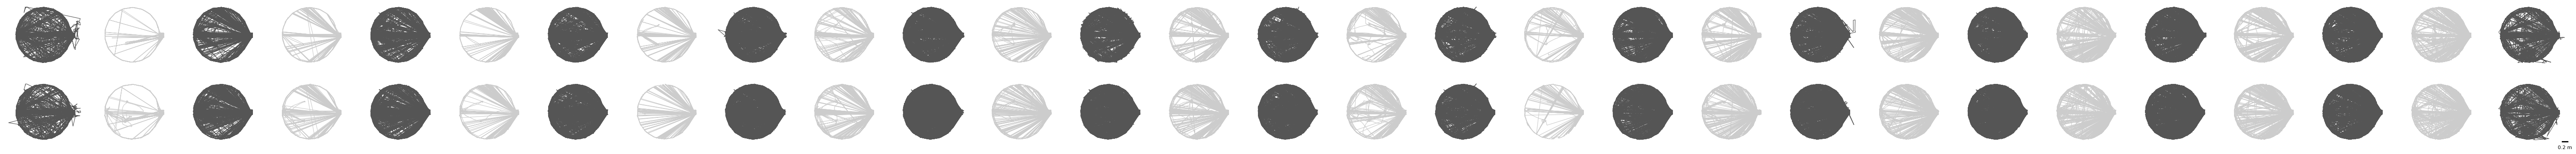

In [50]:
df_plot = df_filtered.reset_index()

dark_color = "#555555"
light_color = "#CCCCCC"
subjects = sorted(df_plot["identity_name"].unique())
n_subj = len(subjects)
n_per = int(df_plot["light_id"].max())

# Set up subplots
fig, axes = plt.subplots(
    nrows=n_subj,
    ncols=n_per,
    figsize=(2 * n_per, 2 * n_subj),
    sharex=True,
    sharey=True,
    squeeze=False,
)

# Loop over axes and draw
for i, subj in enumerate(subjects):
    for j in range(1, n_per + 1):
        ax = axes[i, j - 1]
        sub = df_plot[(df_plot.identity_name == subj) & (df_plot.light_id == j)]
        if sub.empty:
            ax.set_axis_off()
            continue

        col = dark_color if sub.is_dark.iloc[0] else light_color

        plot_in_chunks(
            ax, sub.x.values, sub.y.values, linestyle="-", linewidth=0.8, color=col
        )
        ax.set_aspect("equal", "box")
        ax.axis("off")

# Scale bar in bottom-right
last_ax = axes[-1, -1]
length_px = 0.2 * 100 * cm2px
xmin, xmax = last_ax.get_xlim()
ymin, ymax = last_ax.get_ylim()
x1 = xmax - 0.02 * (xmax - xmin)
x0 = x1 - length_px
y0 = ymin + 0.02 * (ymax - ymin)
last_ax.plot([x0, x1], [y0, y0], "k-", lw=2)
last_ax.text(
    (x0 + x1) / 2,
    y0 - 0.06 * (ymax - ymin),
    "0.2 m",
    va="top",
    ha="center",
    fontsize=8,
    color="k",
)

plt.tight_layout()

# svg_path = save_dir / "position_maps.pdf"
# plt.savefig(svg_path, format="pdf", dpi=300)

plt.show()

### 2. Locomotion speed over time per subject

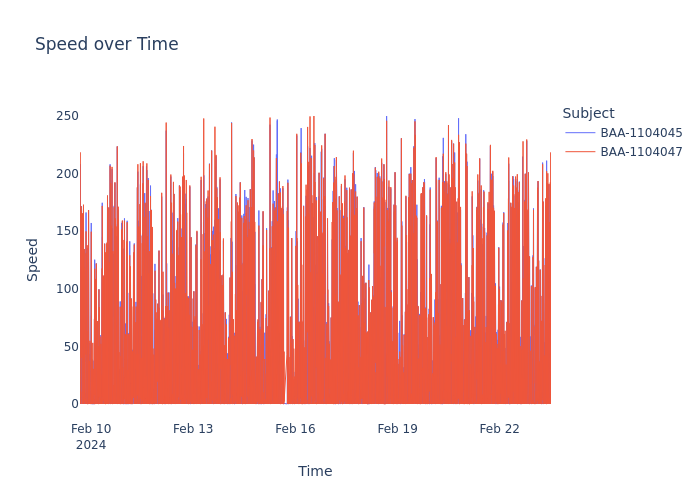

In [51]:
df_speed = df_filtered.copy()
df_speed.index.name = "time"

dark_color = "#555555"
light_color = "#CCCCCC"
subjects = sorted(df_speed["identity_name"].unique())

agg = (
    df_speed[["identity_name", "speed"]]
    .groupby("identity_name")
    .resample("1s")
    .mean()
    .dropna()
    .reset_index()
)

fig = go.Figure()
for subj in subjects:
    sub = agg[agg["identity_name"] == subj]
    fig.add_trace(
        go.Scatter(
            x=sub["time"],
            y=sub["speed"],
            mode="lines",
            name=subj,
            line=dict(width=1),
            opacity=1,
        )
    )

fig.update_layout(
    title="Speed over Time",
    xaxis_title="Time",
    yaxis_title="Speed",
    legend_title="Subject",
    plot_bgcolor="white",
)

# pio.write_image(
#     fig,
#     str(save_dir / "speed_over_time.svg"),
#     format="svg"
# )

fig.show()

### 3. Foraging bouts raster plot

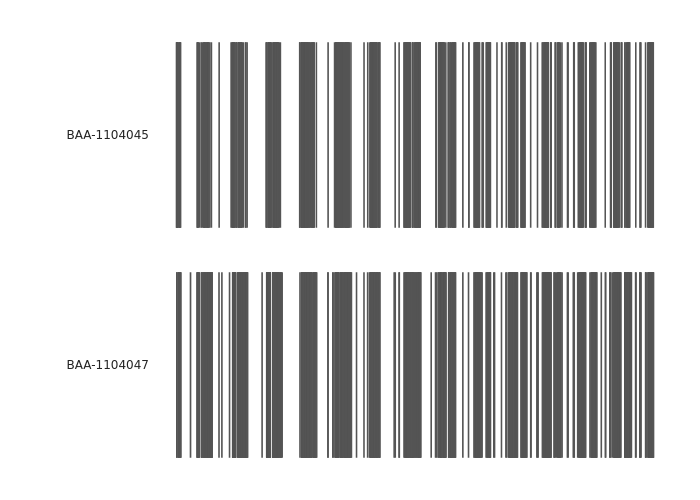

In [52]:
dark_color = "#555555"
subjects = sorted(social_foraging_df["subject"].unique())

fig = px.timeline(
    social_foraging_df,
    x_start="start",
    x_end="end",
    y="subject",
    hover_data=["n_pellets", "cum_wheel_dist"],
    category_orders={"subject": subjects},
)

fig.update_traces(
    opacity=1,
    marker_color=dark_color,
    marker_line_color=dark_color,
    marker_line_width=1.5,
)

fig.update_layout(
    template="simple_white",
    plot_bgcolor="white",
    margin=dict(l=150, r=20, t=20, b=20),
    height=max(100, len(subjects) * 25 + 50),
    xaxis=dict(
        showgrid=False, zeroline=False, showline=False, ticks="", showticklabels=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks="",
        showticklabels=True,
        title="",
    ),
)

# pio.write_image(
#     fig,
#     str(save_dir / "foraging_bouts_raster.svg"),
#     format="svg"
# )

fig.show()

### 4. Wheel distance spun 

#### Over time per subject patch

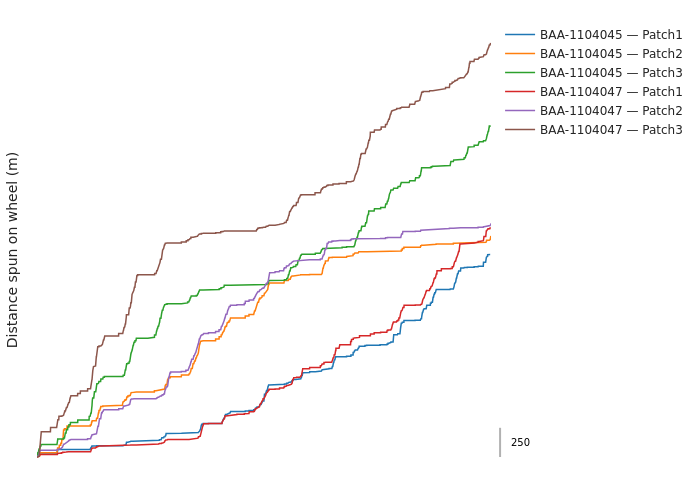

In [53]:
dt_seconds = 0.02

fig = go.Figure()

# Build each trace (continuous + Δ>0.5 downsample)
max_y = 0
for (subject, patch), grp in social_patch_df.groupby(["subject_name", "patch_name"]):
    grp = grp.sort_values("block_start")
    total_n = sum(len(a) for a in grp.wheel_cumsum_distance_travelled)

    times = np.empty(total_n, dtype="datetime64[ns]")
    dists = np.empty(total_n, dtype=float)
    idx, offset = 0, 0.0

    for bs_val, arr in zip(grp.block_start, grp.wheel_cumsum_distance_travelled):
        arr = np.asarray(arr)
        n = arr.size
        offs = (np.arange(n) * dt_seconds * 1e9).astype("timedelta64[ns]")
        times[idx : idx + n] = np.datetime64(bs_val) + offs
        dists[idx : idx + n] = arr + offset
        offset += arr[-1]
        idx += n

    max_y = max(max_y, dists.max())

    # Downsample
    diffs = np.abs(np.diff(dists, prepend=dists[0]))
    mask = diffs > 0.5
    mask[0] = True

    fig.add_trace(
        go.Scatter(
            x=times[mask],
            y=dists[mask] / 100,  # convert to meters
            mode="lines",
            name=f"{subject} — {patch}",
            line=dict(width=1.5),
        )
    )

# Hide all ticks and tick lines; keep only the y-axis title
fig.update_xaxes(
    showgrid=False, zeroline=False, showline=False, showticklabels=False, ticks=""
)
fig.update_yaxes(
    title_text="Distance spun on wheel (m)",
    showgrid=False,
    zeroline=False,
    showline=False,
    showticklabels=False,
    ticks="",
)

# Vertical scale bar: 250 m high at the right edge
fig.add_shape(
    type="line",
    xref="paper",
    x0=1.02,
    x1=1.02,
    yref="y",
    y0=0,
    y1=250,
    line=dict(color="black", width=2),
)
fig.add_annotation(
    xref="paper",
    x=1.04,
    y=125,
    text="250",
    showarrow=False,
    xanchor="left",
    yanchor="middle",
    font=dict(size=10, color="black"),
)

# Layout tweaks and show
fig.update_layout(
    template="simple_white", margin=dict(l=20, r=80, t=20, b=20), showlegend=True
)

# pio.write_image(
#     fig,
#     str(save_dir / "wheel_dist_over_time.svg"),
#     format="svg"
# )

fig.show(
    config={
        "staticPlot": True,
    }
)

#### Dummy patch vs normal patches

In [ ]:
patch_dfs = []

for exp in [experiments[i] for i in [4, 5]]:
    data = load_experiment_data(experiment=exp, data_dir=data_dir, data_types=["patch"])
    df = data["None_patch"]
    patch_dfs.append(df)

patch_df_s4 = pd.concat(patch_dfs).sort_index()

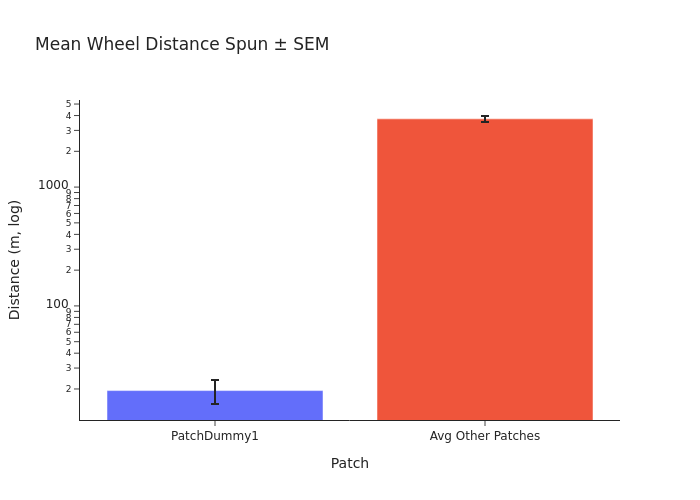

In [55]:
dt_seconds = 0.02
summary = []

# Compute total distance spun per (subject, patch)
for (subject, patch), grp in patch_df_s4.groupby(["subject_name", "patch_name"]):
    total_distance = sum(
        np.asarray(w)[-1] for w in grp["wheel_cumsum_distance_travelled"] if len(w) > 0
    )
    summary.append(
        {"subject": subject, "patch": patch, "distance": total_distance / 100}
    )  # convert to meters

summary_df = pd.DataFrame(summary)

# Pivot to subject x patch format
pivot_df = summary_df.pivot(index="subject", columns="patch", values="distance").fillna(
    0
)

# Per-subject values for PatchDummy1 and mean of other patches
patch_dummy1_vals = pivot_df.get("PatchDummy1", pd.Series(0, index=pivot_df.index))
other_patch_vals = pivot_df.drop(columns="PatchDummy1", errors="ignore").mean(axis=1)

# Compute means and SEMs
means = [patch_dummy1_vals.mean(), other_patch_vals.mean()]
sems = [patch_dummy1_vals.sem(), other_patch_vals.sem()]
labels = ["PatchDummy1", "Avg Other Patches"]

# Plot
fig = go.Figure(
    data=[
        go.Bar(
            x=labels,
            y=means,
            error_y=dict(type="data", array=sems, visible=True),
            marker_color=["#636EFA", "#EF553B"],
        )
    ]
)

fig.update_layout(
    title="Mean Wheel Distance Spun ± SEM",
    yaxis_title="Distance (m, log)",
    xaxis_title="Patch",
    yaxis_type="log",
    template="simple_white",
    height=400,
)

# pio.write_image(
#     fig,
#     str(save_dir / "dummy_vs_normal_patches.svg"),
#     format="svg"
# )

fig.show()

In [56]:
display(patch_dummy1_vals, other_patch_vals)

t_stat, p_val = ttest_rel(patch_dummy1_vals, other_patch_vals)
print(f"Paired t‐statistic = {t_stat:.3f},  p‐value = {p_val:.4f}")

subject
BAA-1104792    25.288925
BAA-1104794    20.960074
BAA-1104795    24.882764
BAA-1104797     6.401984
Name: PatchDummy1, dtype: float64

subject
BAA-1104792    4300.985857
BAA-1104794    3847.328388
BAA-1104795    3551.048284
BAA-1104797    3306.791160
dtype: float64

Paired t‐statistic = -17.706,  p‐value = 0.0004


### 5. Pellets raster plot

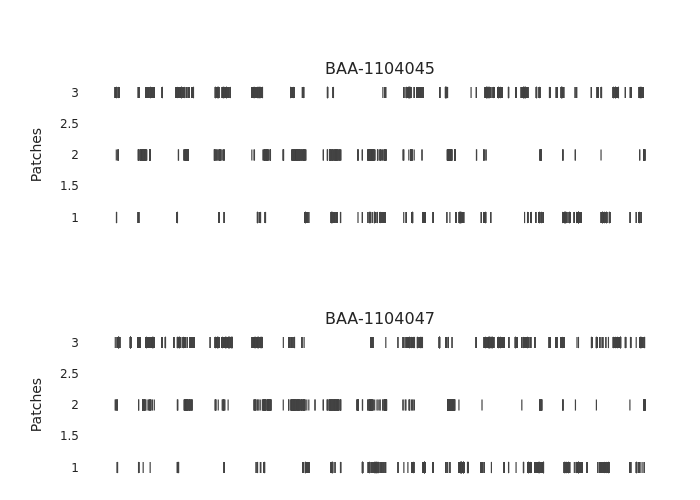

In [57]:
df = (
    social_patch_df[["subject_name", "patch_name", "pellet_timestamps"]]
    .explode("pellet_timestamps")
    .dropna(subset=["pellet_timestamps"])
)
df["pellet_timestamps"] = pd.to_datetime(df["pellet_timestamps"])
df["patch_idx"] = df["patch_name"].str.extract(r"(\d+)$").astype(int)

dark_color = "#555555"
subjects = sorted(df["subject_name"].unique())
n_subj = len(subjects)

fig = make_subplots(rows=n_subj, cols=1, shared_xaxes=True, subplot_titles=subjects)

for i, subj in enumerate(subjects, start=1):
    sub = df[df["subject_name"] == subj]
    fig.add_trace(
        go.Scatter(
            x=sub["pellet_timestamps"],
            y=sub["patch_idx"],
            mode="markers",
            marker=dict(symbol="line-ns", color=dark_color, size=8, line_width=1.2),
            showlegend=False,
        ),
        row=i,
        col=1,
    )
    # Y-axis = patch numbers
    fig.update_yaxes(
        row=i,
        col=1,
        title="Patches",
        tickmode="array",
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks="",
    )
    # Remove x-labels on every row
    fig.update_xaxes(
        row=i,
        col=1,
        showticklabels=False,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks="",
    )

# Tighten the margins and overall height
fig.update_layout(
    template="simple_white",
    plot_bgcolor="white",
    margin=dict(l=80, r=20, t=80, b=20),
    height=120 * n_subj,
)

# Center subject titles
for ann in fig.layout.annotations:
    ann.x = 0.5
    ann.xanchor = "center"
    ann.font = dict(size=16)

# pio.write_image(
#     fig,
#     str(save_dir / "pellets_raster.svg"),
#     format="svg"
# )

fig.show()

### 6. Weight over time

#### Per subject for a single experiment

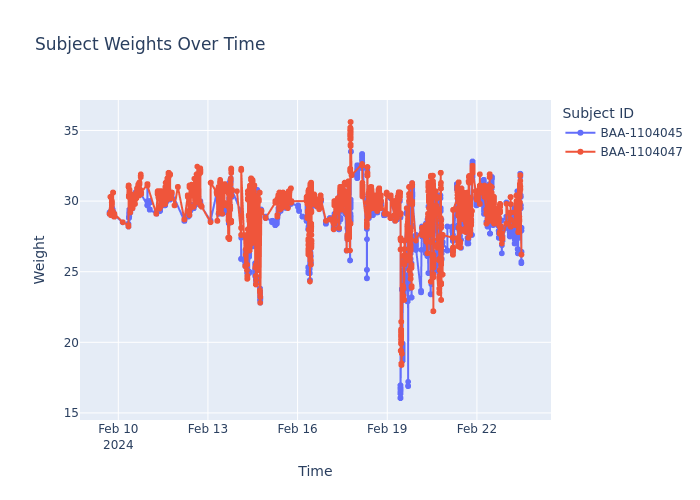

In [58]:
# Keep only rows that have timestamps
df = social_weight_df[
    social_weight_df["timestamps"].apply(lambda lst: len(lst) > 0)
].copy()

# Explode parallel list-columns into long form
df = df.explode(["timestamps", "weight", "subject_id"])

# Type conversions
df["timestamps"] = pd.to_datetime(df["timestamps"])
df["weight"] = df["weight"].astype(float)

# Plot
fig = px.line(
    df,
    x="timestamps",
    y="weight",
    color="subject_id",
    markers=True,
    title="Subject Weights Over Time",
    labels={"timestamps": "Time", "weight": "Weight", "subject_id": "Subject ID"},
)
fig.update_layout(legend_title_text="Subject ID")
fig.show()

#### Averaged over time

In [ ]:
social_weight_dfs = []

for exp in [experiments[i] for i in [0, 1, 4, 5]]:
    data = load_experiment_data(
        experiment=exp, data_dir=data_dir, periods=["social"], data_types=["weight"]
    )
    df = data["social_weight"]
    social_weight_dfs.append(df)

social_weight_df_all_exps = pd.concat(social_weight_dfs).sort_index()

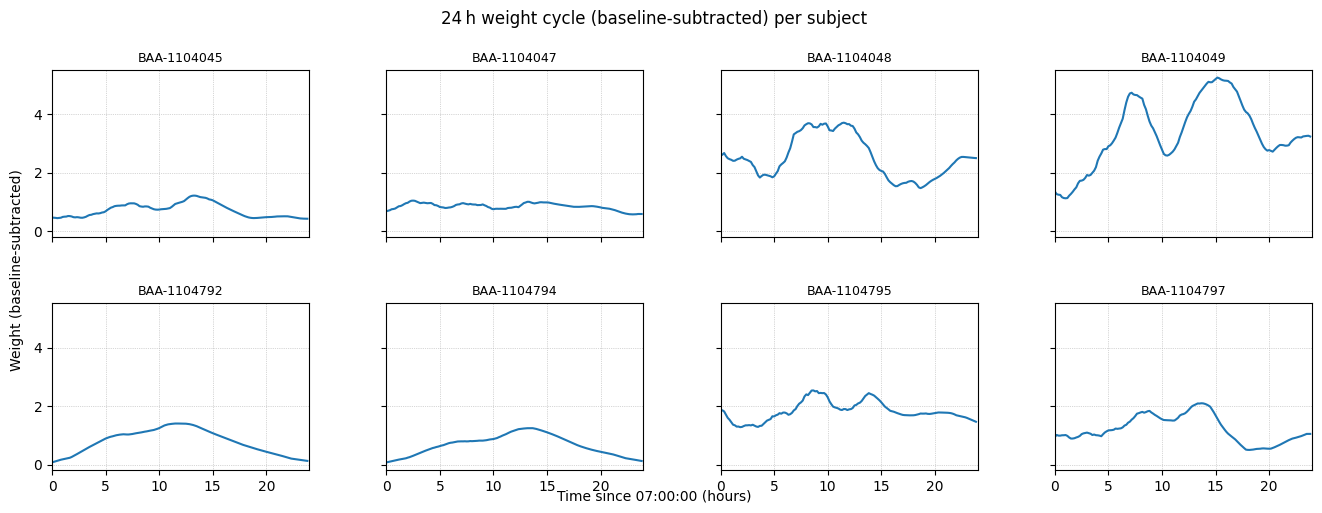

In [60]:
# Flatten the “array-of-arrays” df into a long DataFrame
records = []
for _, row in social_weight_df_all_exps.iterrows():
    ts = pd.to_datetime(row["timestamps"])
    w = np.asarray(row["weight"], dtype=float)
    sids = row["subject_id"]
    for t, weight, sid in zip(ts, w, sids):
        records.append({"timestamp": t, "subject_id": sid, "weight": weight})

df = pd.DataFrame.from_records(records)
df = df.sort_values(["subject_id", "timestamp"])
# Drop rows where subject_id is shorter than 11 characters, removes some erroneous entries
df = df[df["subject_id"].str.len() >= 11].reset_index(drop=True)

# Parameters & 24 h cycle grid
sampling_freq = "10min"  # resample interval
# Choose any date at 08:00 to define “day zero”
anchor = pd.Timestamp(f"2020-01-01 {light_off:02d}:00:00")

# Build the 24 h cycle index
n_steps = int(pd.Timedelta("1D") / pd.Timedelta(sampling_freq))
cycle_index = pd.timedelta_range(start=0, periods=n_steps, freq=sampling_freq)

# Will hold each mouse’s mean‐day
cycle_df = pd.DataFrame(index=cycle_index)

# Loop over each mouse, resample, fold into 24 h, average days
for sid, grp in df.groupby("subject_id"):
    # Series of weight vs time
    ser = grp.set_index("timestamp")["weight"].sort_index()
    # Collapse any exact-duplicate timestamps
    ser = ser.groupby(level=0).mean()

    # Resample into bins anchored at 08:00, then interpolate
    ser_rs = ser.resample(sampling_freq, origin=anchor).mean().interpolate()

    # Convert each timestamp into its offset (mod 24 h) from the anchor
    offsets = (ser_rs.index - anchor) % pd.Timedelta("1D")
    ser_rs.index = offsets

    # Average across all days for each offset
    daily = ser_rs.groupby(ser_rs.index).mean()

    # Align to uniform cycle grid
    cycle_df[sid] = daily.reindex(cycle_index)

# Baseline‐subtract each mouse’s minimum, then grand‐mean
cycle_df_baselined = cycle_df.subtract(cycle_df.min(skipna=True), axis=1)
grand_mean = cycle_df_baselined.mean(axis=1)
sem = cycle_df_baselined.sem(axis=1)

# Smooth both mean and SEM with a centered rolling window
window = 20
grand_mean_smooth = grand_mean.rolling(window=window, center=True, min_periods=1).mean()
sem_smooth = sem.rolling(window=window, center=True, min_periods=1).mean()

# Plot each subject's mean-day curve in its own subplot
n_subj = cycle_df_baselined.shape[1]
n_cols = 4  # adjust as needed
n_rows = math.ceil(n_subj / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(3.5 * n_cols, 2.5 * n_rows), sharex=True, sharey=True
)
axes = axes.flatten()
x_hours = cycle_df_baselined.index.total_seconds() / 3600

for i, sid in enumerate(cycle_df_baselined.columns):
    ax = axes[i]
    y = cycle_df_baselined[sid]
    y_smooth = y.rolling(window=window, center=True, min_periods=1).mean()
    ax.plot(x_hours, y_smooth, lw=1.5)
    ax.set_title(sid, fontsize=9)
    ax.set_xlim(0, 24)
    ax.grid(True, linestyle=":", linewidth=0.5)

# Remove any unused axes
for ax in axes[n_subj:]:
    ax.set_visible(False)

fig.suptitle("24 h weight cycle (baseline-subtracted) per subject", y=1.02)
fig.text(0.5, 0.04, f"Time since {light_off:02d}:00:00 (hours)", ha="center")
fig.text(0.04, 0.5, "Weight (baseline-subtracted)", va="center", rotation="vertical")
plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.1, left=0.07, right=0.97, top=0.90)
plt.show()

#### Averaged over time and subjects

Baselined by subtracting the minimum of each subject's 24h mean-day curve

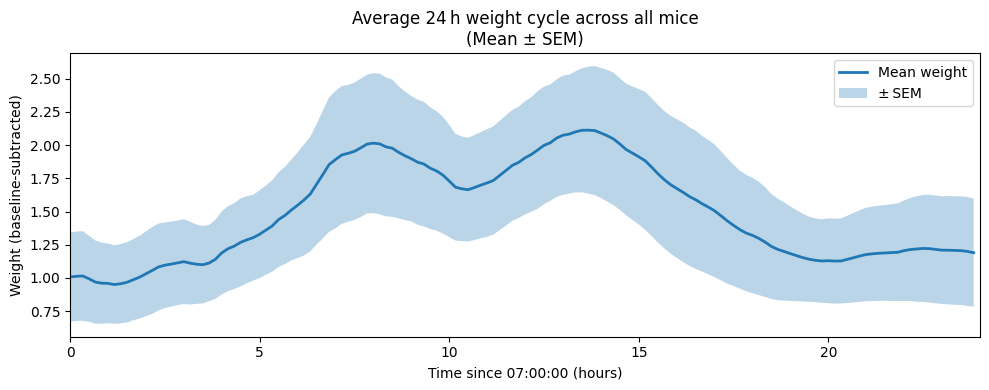

In [61]:
# Flatten the “array-of-arrays” df into a long DataFrame
records = []
for _, row in social_weight_df_all_exps.iterrows():
    ts = pd.to_datetime(row["timestamps"])
    w = np.asarray(row["weight"], dtype=float)
    sids = row["subject_id"]
    for t, weight, sid in zip(ts, w, sids):
        records.append({"timestamp": t, "subject_id": sid, "weight": weight})

df = pd.DataFrame.from_records(records)
df = df.sort_values(["subject_id", "timestamp"])
# Drop rows where subject_id is shorter than 11 characters, removes some erroneous entries
df = df[df["subject_id"].str.len() >= 11].reset_index(drop=True)

# Parameters & 24 h cycle grid
sampling_freq = "10min"  # resample interval
# Choose any date at 08:00 to define “day zero”
anchor = pd.Timestamp(f"2020-01-01 {light_off:02d}:00:00")

# Build the 24 h cycle index
n_steps = int(pd.Timedelta("1D") / pd.Timedelta(sampling_freq))
cycle_index = pd.timedelta_range(start=0, periods=n_steps, freq=sampling_freq)

# Will hold each mouse’s mean‐day
cycle_df = pd.DataFrame(index=cycle_index)

# Loop over each mouse, resample, fold into 24 h, average days
for sid, grp in df.groupby("subject_id"):
    # Series of weight vs time
    ser = grp.set_index("timestamp")["weight"].sort_index()
    # Collapse any exact-duplicate timestamps
    ser = ser.groupby(level=0).mean()

    # Resample into bins anchored at 08:00, then interpolate
    ser_rs = ser.resample(sampling_freq, origin=anchor).mean().interpolate()

    # Convert each timestamp into its offset (mod 24 h) from the anchor
    offsets = (ser_rs.index - anchor) % pd.Timedelta("1D")
    ser_rs.index = offsets

    # Average across all days for each offset
    daily = ser_rs.groupby(ser_rs.index).mean()

    # Align to uniform cycle grid
    cycle_df[sid] = daily.reindex(cycle_index)

# Baseline‐subtract each mouse’s minimum, then grand‐mean
cycle_df_baselined = cycle_df.subtract(cycle_df.min())
grand_mean = cycle_df_baselined.mean(axis=1)
sem = cycle_df_baselined.sem(axis=1)

# Smooth both mean and SEM with a centered rolling window
window = 20
grand_mean_smooth = grand_mean.rolling(window=window, center=True, min_periods=1).mean()
sem_smooth = sem.rolling(window=window, center=True, min_periods=1).mean()

# Plot mean ± SEM
plt.figure(figsize=(10, 4))
x_hours = cycle_df_baselined.index.total_seconds() / 3600

plt.plot(x_hours, grand_mean_smooth, lw=2, label="Mean weight")
plt.fill_between(
    x_hours,
    grand_mean_smooth - sem_smooth,
    grand_mean_smooth + sem_smooth,
    alpha=0.3,
    label="± SEM",
)

plt.xlabel(f"Time since {light_off:02d}:00:00 (hours)")
plt.ylabel("Weight (baseline-subtracted)")
plt.title("Average 24 h weight cycle across all mice\n(Mean ± SEM)")
plt.xlim(0, 24)
plt.legend()
plt.tight_layout()
plt.show()

Baselined by subtracting the minimum of each subject's _smoothed_ 24h mean-day curve

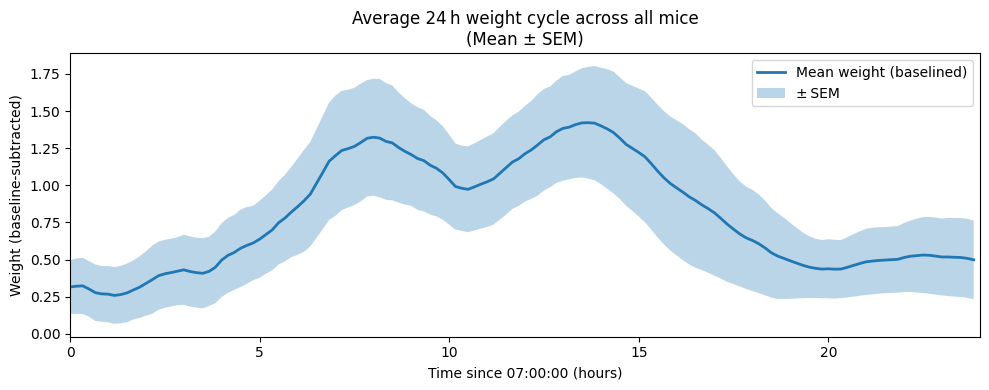

In [62]:
# Flatten the “array-of-arrays” df into a long DataFrame
records = []
for _, row in social_weight_df_all_exps.iterrows():
    ts = pd.to_datetime(row["timestamps"])
    w = np.asarray(row["weight"], dtype=float)
    sids = row["subject_id"]
    for t, weight, sid in zip(ts, w, sids):
        records.append({"timestamp": t, "subject_id": sid, "weight": weight})

df = pd.DataFrame.from_records(records)
df = df.sort_values(["subject_id", "timestamp"])
# Drop rows where subject_id is shorter than 11 characters, removes some erroneous entries
df = df[df["subject_id"].str.len() >= 11].reset_index(drop=True)

# Parameters & 24 h cycle grid
sampling_freq = "10min"  # resample interval
# Choose any date at 08:00 to define “day zero”
anchor = pd.Timestamp(f"2020-01-01 {light_off:02d}:00:00")

# Build the 24 h cycle index
n_steps = int(pd.Timedelta("1D") / pd.Timedelta(sampling_freq))
cycle_index = pd.timedelta_range(start=0, periods=n_steps, freq=sampling_freq)

# Will hold each mouse’s mean‐day (unsmoothed)
cycle_df = pd.DataFrame(index=cycle_index)

# Loop over each mouse, resample, fold into 24 h, average days
for sid, grp in df.groupby("subject_id"):
    # Series of weight vs time
    ser = grp.set_index("timestamp")["weight"].sort_index()
    # Collapse any exact-duplicate timestamps
    ser = ser.groupby(level=0).mean()

    # Resample into bins anchored at 08:00, then interpolate
    ser_rs = ser.resample(sampling_freq, origin=anchor).mean().interpolate()

    # Convert each timestamp into its offset (mod 24 h) from the anchor
    offsets = (ser_rs.index - anchor) % pd.Timedelta("1D")
    ser_rs.index = offsets

    # Average across all days for each offset
    daily = ser_rs.groupby(ser_rs.index).mean()

    # Align to uniform cycle grid
    cycle_df[sid] = daily.reindex(cycle_index)

# Baseline‐subtract using each subject’s smoothed minimum
window = 20  # keep same smoothing window for per‐subject curves
# Smooth each column (i.e., each subject’s 24 h curve)
cycle_df_smooth = cycle_df.rolling(window=window, center=True, min_periods=1).mean()

# Find the minimum of each subject’s smoothed curve
minima_smooth = cycle_df_smooth.min()  # series indexed by subject_id

# Subtract that baseline from the UNSMOOTHED cycle for each subject
cycle_df_baselined = cycle_df.subtract(minima_smooth, axis=1)

# Now compute grand‐mean and SEM (over baselined, unsmoothed curves)
grand_mean = cycle_df_baselined.mean(axis=1)
sem = cycle_df_baselined.sem(axis=1)

# Smooth both grand‐mean and SEM for plotting
grand_mean_smooth = grand_mean.rolling(window=window, center=True, min_periods=1).mean()
sem_smooth = sem.rolling(window=window, center=True, min_periods=1).mean()

# Plot mean ± SEM
plt.figure(figsize=(10, 4))
x_hours = cycle_df_baselined.index.total_seconds() / 3600

plt.plot(x_hours, grand_mean_smooth, lw=2, label="Mean weight (baselined)")
plt.fill_between(
    x_hours,
    grand_mean_smooth - sem_smooth,
    grand_mean_smooth + sem_smooth,
    alpha=0.3,
    label="± SEM",
)

plt.xlabel(f"Time since {light_off:02d}:00:00 (hours)")
plt.ylabel("Weight (baseline‐subtracted)")
plt.title("Average 24 h weight cycle across all mice\n(Mean ± SEM)")
plt.xlim(0, 24)
plt.legend()
plt.tight_layout()

# svg_path = save_dir / "24h_weight_cycle.svg"
# plt.savefig(str(svg_path), format='svg')

plt.show()